<a href="https://colab.research.google.com/github/aegiskeller/Metapath2Vec_On_MovieLens1M/blob/main/Graph_Representation_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
#!pip install umap-learn

In [3]:
import pandas as pd
import networkx as nx
import torch_geometric
import torch
import random
import numpy as np
import os
from umap import UMAP

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2025-02-10 23:45:19--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  9.91MB/s    in 0.6s    

2025-02-10 23:45:20 (9.91 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [5]:
os.listdir('ml-1m/')

['users.dat', 'README', 'movies.dat', 'ratings.dat']

In [6]:
users = pd.read_csv("ml-1m/users.dat", sep='::',header=None, names=['user_id','gender','age','occupation','zip-code'])
users

<ipython-input-6-6253c0152e56>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv("ml-1m/users.dat", sep='::',header=None, names=['user_id','gender','age','occupation','zip-code'])


,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [7]:
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', header=None, names=['user_id','item_id','rating','timestamp'])
ratings

<ipython-input-7-19210744f69a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', header=None, names=['user_id','item_id','rating','timestamp'])


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [9]:
items = pd.read_csv("ml-1m/movies.dat",sep='::', header=None, names=['movie_id','movie_title','genres'], encoding='ISO-8859-1')
items

<ipython-input-9-b93318373b57>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  items = pd.read_csv("ml-1m/movies.dat",sep='::', header=None, names=['movie_id','movie_title','genres'], encoding='ISO-8859-1')


,movie_id,movie_title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [10]:
items['genre_list']=items.genres.str.split('|')
items['genre_list']

,genre_list
0,"[Animation, Children's, Comedy]"
1,"[Adventure, Children's, Fantasy]"
2,"[Comedy, Romance]"
3,"[Comedy, Drama]"
4,[Comedy]
...,...
3878,[Comedy]
3879,[Drama]
3880,[Drama]
3881,[Drama]


In [11]:
genres = ["Action" , "Adventure" , "Animation" ,
  "Children's" , "Comedy" , "Crime" , "Documentary" , "Drama" , "Fantasy" ,
  "Film-Noir" , "Horror" , "Musical" , "Mystery" , "Romance" , "Sci-Fi" ,
  "Thriller" , "War" , "Western"]

genres_to_idx = {k:i for i,k in enumerate(genres)}

def return_genre_idx(x):

    return [genres_to_idx[elem] for elem in x]

items['genre_list_idx']=items['genre_list'].apply(return_genre_idx)
items['genre_list_idx']

,genre_list_idx
0,"[2, 3, 4]"
1,"[1, 3, 8]"
2,"[4, 13]"
3,"[4, 7]"
4,[4]
...,...
3878,[4]
3879,[7]
3880,[7]
3881,[7]


In [12]:
full_table = ratings.merge(items, left_on='item_id',right_on='movie_id')
full_table


,user_id,item_id,rating,timestamp,movie_id,movie_title,genres,genre_list,genre_list_idx
0,1,1193,5,978300760,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
1,1,661,3,978302109,661,James and the Giant Peach (1996),Animation|Children's|Musical,"[Animation, Children's, Musical]","[2, 3, 11]"
2,1,914,3,978301968,914,My Fair Lady (1964),Musical|Romance,"[Musical, Romance]","[11, 13]"
3,1,3408,4,978300275,3408,Erin Brockovich (2000),Drama,[Drama],[7]
4,1,2355,5,978824291,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,"[Animation, Children's, Comedy]","[2, 3, 4]"
...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,1091,Weekend at Bernie's (1989),Comedy,[Comedy],[4]
1000205,6040,1094,5,956704887,1094,"Crying Game, The (1992)",Drama|Romance|War,"[Drama, Romance, War]","[7, 13, 16]"
1000206,6040,562,5,956704746,562,Welcome to the Dollhouse (1995),Comedy|Drama,"[Comedy, Drama]","[4, 7]"
1000207,6040,1096,4,956715648,1096,Sophie's Choice (1982),Drama,[Drama],[7]


In [13]:
edge_index_dict = {}
edge_index_dict[("user_id","has_liked","item_id")] = torch.Tensor(\
    [full_table['user_id'].astype(int).tolist(),
    full_table['item_id'].astype(int).tolist()]).long()


In [14]:
movies_nodes_list = []
genres_nodes_list = []
for index,row in items.iterrows():
    for mov in row['genre_list_idx']:

        movies_nodes_list.append(row['movie_id'])
        genres_nodes_list.append(mov)

edge_index_dict[("item_id","has_genres","genre")]= \
            torch.Tensor([movies_nodes_list,genres_nodes_list]).long()
edge_index_dict[("genre","belongs_to","item_id")]= \
                torch.Tensor([genres_nodes_list,movies_nodes_list]).long()
edge_index_dict[("item_id","liked_by","user_id")] = torch.Tensor(\
    [full_table['item_id'].astype(int).tolist(),full_table['user_id'].astype(int).tolist(),
    ]).long()



In [16]:
from tqdm import tqdm
def train(model, epoch, log_steps=100, eval_steps=2000):
    model.train()
    global loss
    total_loss = 0
    for i, (pos_rw, neg_rw) in tqdm(enumerate(loader)):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to('cuda'), neg_rw.to('cuda'))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))

In [17]:
from torch_geometric.nn import MetaPath2Vec
from itertools import product

metapath=[('user_id',
  'has_liked',
  'item_id'),
('item_id',
  'has_genres',
  'genre'),
('genre',
  'belongs_to',
  'item_id'),
     ('item_id',
  'liked_by',
  'user_id')    ]

embedding_dims = [2**(x) for x in range(5,9)]
walk_length=[10*x for x in range(5,11)]
context_size = [8,16,24,48]
combinations = list(product(embedding_dims,walk_length,context_size))
n_comb = len(combinations)
i=1
models_dict = {}
models_dict["metapath"] = metapath
for tup in combinations:

    models_dict[tup] = {}
    print(f"Trying combination {i} out of {n_comb}")
    print(f"Params of comb {i}: {tup}")
    model = MetaPath2Vec(edge_index_dict=edge_index_dict, embedding_dim=tup[0],metapath=metapath,walk_length=tup[1], context_size=tup[2],
                     walks_per_node=1, num_negative_samples=5,
                     sparse=True).to('cuda')
    loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.025)
    epoch_loss = []
    for epoch in range(1, 11):
        train(model,epoch)
        print(f"epoch: {epoch}, loss: {loss}")
        epoch_loss.append(loss)
    models_dict[tup]["epoch_loss"] = epoch_loss
    models_dict[tup]["trained_model"] = model
    i=i+1






Trying combination 1 out of 96
Params of comb 1: (32, 50, 8)


48it [00:01, 26.17it/s]

epoch: 1, loss: 1.7982121706008911



48it [00:00, 70.49it/s]

epoch: 2, loss: 1.3106250762939453



48it [00:00, 74.65it/s]

epoch: 3, loss: 1.2001467943191528



48it [00:00, 74.04it/s]

epoch: 4, loss: 1.1833322048187256



48it [00:00, 73.74it/s]

epoch: 5, loss: 1.1463080644607544



48it [00:00, 73.86it/s]

epoch: 6, loss: 1.148703694343567



48it [00:00, 73.83it/s]

epoch: 7, loss: 1.1004102230072021



48it [00:00, 75.35it/s]

epoch: 8, loss: 1.1359472274780273



48it [00:00, 74.41it/s]

epoch: 9, loss: 1.115591287612915



48it [00:00, 74.79it/s]


epoch: 10, loss: 1.1410346031188965
Trying combination 2 out of 96
Params of comb 2: (32, 50, 16)


48it [00:00, 63.91it/s]

epoch: 1, loss: 1.731269121170044



48it [00:00, 64.18it/s]

epoch: 2, loss: 1.3211365938186646



48it [00:00, 62.13it/s]

epoch: 3, loss: 1.2034903764724731



48it [00:00, 62.27it/s]

epoch: 4, loss: 1.1800036430358887



48it [00:01, 37.64it/s]

epoch: 5, loss: 1.1589164733886719



48it [00:01, 44.07it/s]

epoch: 6, loss: 1.196643352508545



48it [00:00, 64.60it/s]

epoch: 7, loss: 1.1856365203857422



48it [00:00, 63.60it/s]

epoch: 8, loss: 1.1445523500442505



48it [00:00, 62.58it/s]

epoch: 9, loss: 1.1773438453674316



48it [00:00, 63.61it/s]


epoch: 10, loss: 1.1659789085388184
Trying combination 3 out of 96
Params of comb 3: (32, 50, 24)


48it [00:00, 58.43it/s]

epoch: 1, loss: 1.7396881580352783



48it [00:00, 59.29it/s]

epoch: 2, loss: 1.2244021892547607



48it [00:00, 60.32it/s]

epoch: 3, loss: 1.1943483352661133



48it [00:00, 59.16it/s]

epoch: 4, loss: 1.1649518013000488



48it [00:00, 57.99it/s]

epoch: 5, loss: 1.19032883644104



48it [00:00, 58.60it/s]

epoch: 6, loss: 1.1909517049789429



48it [00:00, 56.85it/s]

epoch: 7, loss: 1.1600091457366943



48it [00:01, 35.63it/s]

epoch: 8, loss: 1.2005380392074585



48it [00:01, 44.86it/s]

epoch: 9, loss: 1.170127034187317



48it [00:00, 59.11it/s]


epoch: 10, loss: 1.1316571235656738
Trying combination 4 out of 96
Params of comb 4: (32, 50, 48)


48it [00:00, 87.32it/s]

epoch: 1, loss: 2.315467119216919



48it [00:00, 86.53it/s]

epoch: 2, loss: 1.5957893133163452



48it [00:00, 90.94it/s]

epoch: 3, loss: 1.4174164533615112



48it [00:00, 86.05it/s]

epoch: 4, loss: 1.3565199375152588



48it [00:00, 78.47it/s]

epoch: 5, loss: 1.2465825080871582



48it [00:00, 86.03it/s]

epoch: 6, loss: 1.2730611562728882



48it [00:00, 83.99it/s]

epoch: 7, loss: 1.2085542678833008



48it [00:00, 82.76it/s]

epoch: 8, loss: 1.254275918006897



48it [00:00, 82.20it/s]

epoch: 9, loss: 1.2476482391357422



48it [00:00, 85.43it/s]


epoch: 10, loss: 1.290539026260376
Trying combination 5 out of 96
Params of comb 5: (32, 60, 8)


48it [00:00, 61.95it/s]

epoch: 1, loss: 1.741912841796875



48it [00:00, 63.05it/s]

epoch: 2, loss: 1.2880735397338867



48it [00:01, 42.46it/s]

epoch: 3, loss: 1.1798070669174194



48it [00:01, 39.93it/s]

epoch: 4, loss: 1.1978240013122559



48it [00:00, 61.07it/s]

epoch: 5, loss: 1.0787379741668701



48it [00:00, 62.46it/s]

epoch: 6, loss: 1.1300820112228394



48it [00:00, 62.42it/s]

epoch: 7, loss: 1.1039317846298218



48it [00:00, 64.52it/s]

epoch: 8, loss: 1.0965049266815186



48it [00:00, 62.20it/s]

epoch: 9, loss: 1.1112831830978394



48it [00:00, 62.85it/s]


epoch: 10, loss: 1.083500623703003
Trying combination 6 out of 96
Params of comb 6: (32, 60, 16)


48it [00:00, 52.75it/s]

epoch: 1, loss: 1.6665222644805908



48it [00:00, 52.87it/s]

epoch: 2, loss: 1.2472786903381348



48it [00:00, 52.59it/s]

epoch: 3, loss: 1.1869231462478638



48it [00:00, 53.05it/s]

epoch: 4, loss: 1.1688188314437866



48it [00:00, 51.40it/s]

epoch: 5, loss: 1.1835932731628418



48it [00:01, 32.20it/s]

epoch: 6, loss: 1.1833833456039429



48it [00:01, 42.32it/s]

epoch: 7, loss: 1.1271637678146362



48it [00:00, 53.59it/s]

epoch: 8, loss: 1.1408979892730713



48it [00:00, 52.38it/s]

epoch: 9, loss: 1.1685750484466553



48it [00:00, 51.42it/s]


epoch: 10, loss: 1.1455798149108887
Trying combination 7 out of 96
Params of comb 7: (32, 60, 24)


48it [00:01, 46.97it/s]

epoch: 1, loss: 1.6861679553985596



48it [00:01, 47.58it/s]

epoch: 2, loss: 1.196335792541504



48it [00:00, 48.43it/s]

epoch: 3, loss: 1.2366902828216553



48it [00:01, 47.30it/s]

epoch: 4, loss: 1.2076297998428345



48it [00:01, 47.02it/s]

epoch: 5, loss: 1.1946544647216797



48it [00:01, 36.95it/s]

epoch: 6, loss: 1.1859121322631836



48it [00:01, 28.75it/s]

epoch: 7, loss: 1.1446213722229004



48it [00:01, 46.27it/s]

epoch: 8, loss: 1.1479501724243164



48it [00:01, 46.23it/s]

epoch: 9, loss: 1.1410399675369263



48it [00:01, 46.87it/s]


epoch: 10, loss: 1.1760919094085693
Trying combination 8 out of 96
Params of comb 8: (32, 60, 48)


48it [00:00, 54.66it/s]

epoch: 1, loss: 1.8326257467269897



48it [00:00, 56.19it/s]

epoch: 2, loss: 1.3267908096313477



48it [00:00, 54.48it/s]

epoch: 3, loss: 1.2468637228012085



48it [00:00, 55.71it/s]

epoch: 4, loss: 1.1927490234375



48it [00:00, 55.74it/s]

epoch: 5, loss: 1.20120370388031



48it [00:00, 55.49it/s]

epoch: 6, loss: 1.239128828048706



48it [00:01, 47.39it/s]

epoch: 7, loss: 1.1791859865188599



48it [00:01, 33.72it/s]

epoch: 8, loss: 1.2159085273742676



48it [00:00, 49.13it/s]

epoch: 9, loss: 1.1953790187835693



48it [00:00, 54.41it/s]


epoch: 10, loss: 1.200864553451538
Trying combination 9 out of 96
Params of comb 9: (32, 70, 8)


48it [00:00, 56.94it/s]

epoch: 1, loss: 1.744706392288208



48it [00:00, 55.78it/s]

epoch: 2, loss: 1.2501311302185059



48it [00:00, 55.51it/s]

epoch: 3, loss: 1.140039086341858



48it [00:00, 54.69it/s]

epoch: 4, loss: 1.0982887744903564



48it [00:00, 56.19it/s]

epoch: 5, loss: 1.1185250282287598



48it [00:00, 56.03it/s]

epoch: 6, loss: 1.0804790258407593



48it [00:00, 54.47it/s]

epoch: 7, loss: 1.1071395874023438



48it [00:00, 56.85it/s]

epoch: 8, loss: 1.0714842081069946



48it [00:01, 47.47it/s]

epoch: 9, loss: 1.0826364755630493



48it [00:01, 35.41it/s]


epoch: 10, loss: 1.101367473602295
Trying combination 10 out of 96
Params of comb 10: (32, 70, 16)


48it [00:01, 44.32it/s]

epoch: 1, loss: 1.5798165798187256



48it [00:01, 45.51it/s]

epoch: 2, loss: 1.2161681652069092



48it [00:01, 41.73it/s]

epoch: 3, loss: 1.2166706323623657



48it [00:01, 44.52it/s]

epoch: 4, loss: 1.1243207454681396



48it [00:01, 44.69it/s]

epoch: 5, loss: 1.149296522140503



48it [00:01, 44.54it/s]

epoch: 6, loss: 1.1829328536987305



48it [00:01, 44.46it/s]

epoch: 7, loss: 1.1773700714111328



48it [00:01, 44.48it/s]

epoch: 8, loss: 1.1546471118927002



48it [00:01, 36.65it/s]

epoch: 9, loss: 1.1661068201065063



48it [00:01, 24.38it/s]


epoch: 10, loss: 1.093170404434204
Trying combination 11 out of 96
Params of comb 11: (32, 70, 24)


48it [00:01, 37.52it/s]

epoch: 1, loss: 1.4134896993637085



48it [00:01, 37.82it/s]

epoch: 2, loss: 1.2328177690505981



48it [00:01, 37.44it/s]

epoch: 3, loss: 1.1686288118362427



48it [00:01, 37.94it/s]

epoch: 4, loss: 1.1771386861801147



48it [00:01, 37.33it/s]

epoch: 5, loss: 1.1595523357391357



48it [00:01, 38.25it/s]

epoch: 6, loss: 1.161940574645996



48it [00:01, 34.04it/s]

epoch: 7, loss: 1.1564545631408691



48it [00:01, 25.02it/s]


epoch: 8, loss: 1.1876169443130493


48it [00:01, 37.81it/s]


epoch: 9, loss: 1.0664024353027344


48it [00:01, 37.59it/s]


epoch: 10, loss: 1.1374350786209106
Trying combination 12 out of 96
Params of comb 12: (32, 70, 48)


48it [00:01, 38.05it/s]

epoch: 1, loss: 1.6400034427642822



48it [00:01, 28.33it/s]

epoch: 2, loss: 1.286898136138916



48it [00:02, 22.90it/s]

epoch: 3, loss: 1.160512924194336



48it [00:01, 35.22it/s]

epoch: 4, loss: 1.2241096496582031



48it [00:02, 21.78it/s]

epoch: 5, loss: 1.2208154201507568



48it [00:01, 34.98it/s]

epoch: 6, loss: 1.1706801652908325



48it [00:01, 34.25it/s]

epoch: 7, loss: 1.1691325902938843



48it [00:01, 35.04it/s]

epoch: 8, loss: 1.1400086879730225



48it [00:01, 35.37it/s]

epoch: 9, loss: 1.1674302816390991



48it [00:01, 35.55it/s]


epoch: 10, loss: 1.168546438217163
Trying combination 13 out of 96
Params of comb 13: (32, 80, 8)


48it [00:01, 30.72it/s]

epoch: 1, loss: 1.594185709953308



48it [00:01, 29.44it/s]

epoch: 2, loss: 1.2006648778915405



48it [00:01, 28.83it/s]

epoch: 3, loss: 1.1345672607421875



48it [00:00, 48.31it/s]

epoch: 4, loss: 1.1249654293060303



48it [00:00, 50.64it/s]

epoch: 5, loss: 1.0756733417510986



48it [00:00, 48.84it/s]

epoch: 6, loss: 1.1000752449035645



48it [00:00, 49.96it/s]

epoch: 7, loss: 1.0733484029769897



48it [00:00, 49.25it/s]

epoch: 8, loss: 1.1022980213165283



48it [00:00, 50.48it/s]

epoch: 9, loss: 1.1090368032455444



48it [00:00, 49.59it/s]


epoch: 10, loss: 1.0291996002197266
Trying combination 14 out of 96
Params of comb 14: (32, 80, 16)


48it [00:01, 38.22it/s]

epoch: 1, loss: 1.5687980651855469



48it [00:01, 31.36it/s]

epoch: 2, loss: 1.2044034004211426



48it [00:01, 26.18it/s]

epoch: 3, loss: 1.1365782022476196



48it [00:01, 36.20it/s]

epoch: 4, loss: 1.156101942062378



48it [00:01, 38.31it/s]

epoch: 5, loss: 1.0997064113616943



48it [00:01, 38.48it/s]


epoch: 6, loss: 1.0524358749389648


48it [00:01, 36.99it/s]

epoch: 7, loss: 1.106515645980835



48it [00:01, 38.63it/s]

epoch: 8, loss: 1.1278806924819946



48it [00:01, 37.90it/s]

epoch: 9, loss: 1.086033821105957



48it [00:01, 37.77it/s]


epoch: 10, loss: 1.105684518814087
Trying combination 15 out of 96
Params of comb 15: (32, 80, 24)


48it [00:02, 21.85it/s]

epoch: 1, loss: 1.4860165119171143



48it [00:01, 32.09it/s]

epoch: 2, loss: 1.2465918064117432



48it [00:01, 31.82it/s]

epoch: 3, loss: 1.110422968864441



48it [00:01, 32.24it/s]

epoch: 4, loss: 1.1188225746154785



48it [00:01, 32.71it/s]

epoch: 5, loss: 1.1312440633773804



48it [00:01, 32.29it/s]

epoch: 6, loss: 1.0116989612579346



48it [00:01, 32.61it/s]


epoch: 7, loss: 1.1180607080459595


48it [00:02, 22.90it/s]

epoch: 8, loss: 1.0764142274856567



48it [00:01, 28.53it/s]

epoch: 9, loss: 1.1196728944778442



48it [00:01, 32.47it/s]


epoch: 10, loss: 1.108594536781311
Trying combination 16 out of 96
Params of comb 16: (32, 80, 48)


48it [00:01, 28.75it/s]


epoch: 1, loss: 1.5366592407226562


48it [00:01, 28.82it/s]

epoch: 2, loss: 1.204304575920105



48it [00:01, 28.49it/s]

epoch: 3, loss: 1.1530050039291382



48it [00:01, 28.57it/s]

epoch: 4, loss: 1.158755898475647



48it [00:02, 18.94it/s]

epoch: 5, loss: 1.1480501890182495



48it [00:01, 28.87it/s]

epoch: 6, loss: 1.1229724884033203



48it [00:01, 28.95it/s]

epoch: 7, loss: 1.1542737483978271



48it [00:01, 29.01it/s]

epoch: 8, loss: 1.1388192176818848



48it [00:01, 28.71it/s]

epoch: 9, loss: 1.132072925567627



48it [00:01, 28.35it/s]


epoch: 10, loss: 1.1086724996566772
Trying combination 17 out of 96
Params of comb 17: (32, 90, 8)


48it [00:01, 39.02it/s]

epoch: 1, loss: 1.4632068872451782



48it [00:01, 28.07it/s]

epoch: 2, loss: 1.1414920091629028



48it [00:01, 44.94it/s]

epoch: 3, loss: 1.1170146465301514



48it [00:01, 44.43it/s]

epoch: 4, loss: 1.0832184553146362



48it [00:01, 44.56it/s]

epoch: 5, loss: 1.0955373048782349



48it [00:01, 45.07it/s]

epoch: 6, loss: 1.1118459701538086



48it [00:01, 44.51it/s]

epoch: 7, loss: 1.045412540435791



48it [00:01, 43.04it/s]

epoch: 8, loss: 1.0629558563232422



48it [00:01, 44.29it/s]

epoch: 9, loss: 1.0924413204193115



48it [00:01, 44.08it/s]


epoch: 10, loss: 1.0709679126739502
Trying combination 18 out of 96
Params of comb 18: (32, 90, 16)


48it [00:02, 23.70it/s]

epoch: 1, loss: 1.4365510940551758



48it [00:01, 28.87it/s]

epoch: 2, loss: 1.1649419069290161



48it [00:01, 33.95it/s]

epoch: 3, loss: 1.1180768013000488



48it [00:01, 34.16it/s]

epoch: 4, loss: 1.0878440141677856



48it [00:01, 33.70it/s]

epoch: 5, loss: 1.101669430732727



48it [00:01, 33.55it/s]

epoch: 6, loss: 1.0895442962646484



48it [00:01, 33.51it/s]

epoch: 7, loss: 1.0810317993164062



48it [00:01, 33.35it/s]

epoch: 8, loss: 1.068709373474121



48it [00:02, 21.81it/s]

epoch: 9, loss: 1.1041374206542969



48it [00:01, 33.34it/s]


epoch: 10, loss: 1.1488018035888672
Trying combination 19 out of 96
Params of comb 19: (32, 90, 24)


48it [00:01, 27.38it/s]

epoch: 1, loss: 1.4916987419128418



48it [00:01, 27.85it/s]

epoch: 2, loss: 1.1785740852355957



48it [00:01, 27.68it/s]

epoch: 3, loss: 1.1230450868606567



48it [00:01, 27.78it/s]

epoch: 4, loss: 1.1295592784881592



48it [00:02, 21.15it/s]

epoch: 5, loss: 1.145032286643982



48it [00:02, 23.89it/s]

epoch: 6, loss: 1.1300190687179565



48it [00:01, 27.42it/s]


epoch: 7, loss: 1.0912411212921143


48it [00:01, 26.22it/s]

epoch: 8, loss: 1.1034071445465088



48it [00:01, 27.59it/s]

epoch: 9, loss: 1.0560616254806519



48it [00:01, 27.90it/s]


epoch: 10, loss: 1.1442843675613403
Trying combination 20 out of 96
Params of comb 20: (32, 90, 48)


48it [00:02, 17.39it/s]


epoch: 1, loss: 1.4366785287857056


48it [00:02, 20.66it/s]

epoch: 2, loss: 1.172515869140625



48it [00:02, 22.16it/s]

epoch: 3, loss: 1.1276416778564453



48it [00:02, 22.42it/s]

epoch: 4, loss: 1.1194219589233398



48it [00:02, 22.02it/s]

epoch: 5, loss: 1.099029779434204



48it [00:02, 19.62it/s]

epoch: 6, loss: 1.157688021659851



48it [00:02, 19.39it/s]


epoch: 7, loss: 1.1127002239227295


48it [00:02, 22.08it/s]

epoch: 8, loss: 1.079005241394043



48it [00:02, 22.40it/s]

epoch: 9, loss: 1.1167933940887451



48it [00:02, 22.22it/s]


epoch: 10, loss: 1.1483805179595947
Trying combination 21 out of 96
Params of comb 21: (32, 100, 8)


48it [00:01, 40.25it/s]

epoch: 1, loss: 1.5145232677459717



48it [00:01, 27.85it/s]

epoch: 2, loss: 1.174851894378662



48it [00:01, 30.59it/s]

epoch: 3, loss: 1.0956755876541138



48it [00:01, 40.40it/s]

epoch: 4, loss: 1.0486867427825928



48it [00:01, 40.32it/s]

epoch: 5, loss: 1.0273622274398804



48it [00:01, 38.86it/s]

epoch: 6, loss: 1.1082086563110352



48it [00:01, 40.52it/s]

epoch: 7, loss: 1.0410622358322144



48it [00:01, 40.15it/s]

epoch: 8, loss: 1.0914329290390015



48it [00:01, 39.96it/s]

epoch: 9, loss: 1.0694434642791748



48it [00:01, 39.40it/s]


epoch: 10, loss: 1.088512897491455
Trying combination 22 out of 96
Params of comb 22: (32, 100, 16)


48it [00:02, 18.34it/s]

epoch: 1, loss: 1.411160945892334



48it [00:02, 21.18it/s]

epoch: 2, loss: 1.1162989139556885



48it [00:01, 29.67it/s]

epoch: 3, loss: 1.1105585098266602



48it [00:01, 30.01it/s]

epoch: 4, loss: 1.0909276008605957



48it [00:01, 29.43it/s]

epoch: 5, loss: 1.0608738660812378



48it [00:01, 28.72it/s]

epoch: 6, loss: 1.0992588996887207



48it [00:02, 22.75it/s]

epoch: 7, loss: 1.0896469354629517



48it [00:01, 24.86it/s]

epoch: 8, loss: 1.1292450428009033



48it [00:01, 28.22it/s]

epoch: 9, loss: 1.090772271156311



48it [00:01, 29.90it/s]


epoch: 10, loss: 1.0302481651306152
Trying combination 23 out of 96
Params of comb 23: (32, 100, 24)


48it [00:02, 23.26it/s]

epoch: 1, loss: 1.3870489597320557



48it [00:02, 22.46it/s]

epoch: 2, loss: 1.118007779121399



48it [00:02, 18.02it/s]

epoch: 3, loss: 1.1281744241714478



48it [00:02, 21.96it/s]

epoch: 4, loss: 1.0551496744155884



48it [00:02, 23.82it/s]

epoch: 5, loss: 1.0978336334228516



48it [00:02, 23.86it/s]

epoch: 6, loss: 1.0697810649871826



48it [00:02, 23.50it/s]

epoch: 7, loss: 1.0402984619140625



48it [00:02, 23.54it/s]

epoch: 8, loss: 1.0984702110290527



48it [00:02, 17.29it/s]


epoch: 9, loss: 1.0904921293258667


48it [00:02, 23.82it/s]


epoch: 10, loss: 1.0486717224121094
Trying combination 24 out of 96
Params of comb 24: (32, 100, 48)


48it [00:02, 17.80it/s]

epoch: 1, loss: 1.4883356094360352



48it [00:02, 17.31it/s]

epoch: 2, loss: 1.1642897129058838



48it [00:03, 14.84it/s]

epoch: 3, loss: 1.1381950378417969



48it [00:02, 16.80it/s]

epoch: 4, loss: 1.149017572402954



48it [00:02, 17.90it/s]

epoch: 5, loss: 1.1446651220321655



48it [00:02, 17.80it/s]

epoch: 6, loss: 1.0764310359954834



48it [00:02, 16.23it/s]

epoch: 7, loss: 1.1064056158065796



48it [00:03, 15.64it/s]

epoch: 8, loss: 1.1128488779067993



48it [00:02, 18.08it/s]

epoch: 9, loss: 1.147355079650879



48it [00:02, 17.79it/s]


epoch: 10, loss: 1.136252522468567
Trying combination 25 out of 96
Params of comb 25: (64, 50, 8)


48it [00:00, 63.86it/s]

epoch: 1, loss: 2.392554521560669



48it [00:00, 62.50it/s]

epoch: 2, loss: 1.5734736919403076



48it [00:00, 60.75it/s]

epoch: 3, loss: 1.27692711353302



48it [00:01, 37.81it/s]

epoch: 4, loss: 1.183260202407837



48it [00:01, 45.71it/s]

epoch: 5, loss: 1.166279673576355



48it [00:00, 65.12it/s]

epoch: 6, loss: 1.1828603744506836



48it [00:00, 66.14it/s]

epoch: 7, loss: 1.119178056716919



48it [00:00, 64.85it/s]

epoch: 8, loss: 1.1266065835952759



48it [00:00, 65.86it/s]


epoch: 9, loss: 1.0911115407943726


48it [00:00, 61.14it/s]


epoch: 10, loss: 1.1581040620803833
Trying combination 26 out of 96
Params of comb 26: (64, 50, 16)


48it [00:00, 52.11it/s]

epoch: 1, loss: 2.3665285110473633



48it [00:00, 52.51it/s]

epoch: 2, loss: 1.425595998764038



48it [00:00, 54.54it/s]

epoch: 3, loss: 1.2615290880203247



48it [00:00, 52.97it/s]

epoch: 4, loss: 1.2196483612060547



48it [00:00, 53.13it/s]

epoch: 5, loss: 1.2489458322525024



48it [00:01, 34.34it/s]

epoch: 6, loss: 1.1798659563064575



48it [00:01, 39.33it/s]

epoch: 7, loss: 1.1438956260681152



48it [00:00, 53.08it/s]

epoch: 8, loss: 1.147589921951294



48it [00:00, 52.91it/s]

epoch: 9, loss: 1.1076021194458008



48it [00:00, 52.86it/s]


epoch: 10, loss: 1.1615355014801025
Trying combination 27 out of 96
Params of comb 27: (64, 50, 24)


48it [00:01, 47.19it/s]

epoch: 1, loss: 2.2990634441375732



48it [00:00, 48.70it/s]

epoch: 2, loss: 1.4973660707473755



48it [00:00, 48.20it/s]

epoch: 3, loss: 1.267366886138916



48it [00:00, 48.42it/s]

epoch: 4, loss: 1.2212141752243042



48it [00:00, 48.85it/s]

epoch: 5, loss: 1.2019908428192139



48it [00:01, 44.44it/s]

epoch: 6, loss: 1.211416244506836



48it [00:01, 31.55it/s]

epoch: 7, loss: 1.1334550380706787



48it [00:01, 43.83it/s]

epoch: 8, loss: 1.1778745651245117



48it [00:00, 48.48it/s]

epoch: 9, loss: 1.1857850551605225



48it [00:01, 47.66it/s]


epoch: 10, loss: 1.1833336353302002
Trying combination 28 out of 96
Params of comb 28: (64, 50, 48)


48it [00:00, 78.41it/s]

epoch: 1, loss: 3.246447801589966



48it [00:00, 79.02it/s]

epoch: 2, loss: 2.126143217086792



48it [00:00, 68.93it/s]

epoch: 3, loss: 1.706542730331421



48it [00:00, 79.82it/s]

epoch: 4, loss: 1.48588228225708



48it [00:00, 80.43it/s]

epoch: 5, loss: 1.4304184913635254



48it [00:00, 74.93it/s]

epoch: 6, loss: 1.3146485090255737



48it [00:00, 74.47it/s]

epoch: 7, loss: 1.3422026634216309



48it [00:00, 73.43it/s]

epoch: 8, loss: 1.308883547782898



48it [00:00, 78.16it/s]

epoch: 9, loss: 1.240407109260559



48it [00:01, 47.61it/s]


epoch: 10, loss: 1.2268222570419312
Trying combination 29 out of 96
Params of comb 29: (64, 60, 8)


48it [00:01, 42.42it/s]

epoch: 1, loss: 2.4527223110198975



48it [00:00, 55.84it/s]

epoch: 2, loss: 1.4011836051940918



48it [00:00, 56.20it/s]

epoch: 3, loss: 1.2065340280532837



48it [00:00, 57.46it/s]

epoch: 4, loss: 1.1243534088134766



48it [00:00, 56.58it/s]

epoch: 5, loss: 1.1066875457763672



48it [00:00, 56.13it/s]

epoch: 6, loss: 1.1170257329940796



48it [00:00, 57.09it/s]

epoch: 7, loss: 1.1509113311767578



48it [00:00, 57.77it/s]

epoch: 8, loss: 1.153587818145752



48it [00:00, 56.85it/s]

epoch: 9, loss: 1.1273921728134155



48it [00:00, 57.44it/s]


epoch: 10, loss: 1.1324694156646729
Trying combination 30 out of 96
Params of comb 30: (64, 60, 16)


48it [00:01, 35.76it/s]

epoch: 1, loss: 2.0743279457092285



48it [00:01, 29.75it/s]

epoch: 2, loss: 1.3853219747543335



48it [00:01, 43.75it/s]

epoch: 3, loss: 1.2410478591918945



48it [00:01, 44.41it/s]

epoch: 4, loss: 1.1951442956924438



48it [00:01, 43.34it/s]

epoch: 5, loss: 1.1680457592010498



48it [00:01, 43.26it/s]

epoch: 6, loss: 1.1520190238952637



48it [00:01, 43.59it/s]

epoch: 7, loss: 1.0956794023513794



48it [00:01, 43.04it/s]

epoch: 8, loss: 1.1367757320404053



48it [00:01, 43.48it/s]

epoch: 9, loss: 1.0954147577285767



48it [00:01, 43.39it/s]


epoch: 10, loss: 1.1186875104904175
Trying combination 31 out of 96
Params of comb 31: (64, 60, 24)


48it [00:01, 24.92it/s]

epoch: 1, loss: 2.081458330154419



48it [00:01, 38.61it/s]

epoch: 2, loss: 1.329432487487793



48it [00:01, 38.90it/s]

epoch: 3, loss: 1.2256832122802734



48it [00:01, 39.28it/s]

epoch: 4, loss: 1.1786742210388184



48it [00:01, 37.79it/s]

epoch: 5, loss: 1.119241714477539



48it [00:01, 38.64it/s]

epoch: 6, loss: 1.1215791702270508



48it [00:01, 38.97it/s]


epoch: 7, loss: 1.161074161529541


48it [00:01, 39.49it/s]


epoch: 8, loss: 1.1774928569793701


48it [00:01, 32.00it/s]

epoch: 9, loss: 1.1414389610290527



48it [00:01, 28.07it/s]


epoch: 10, loss: 1.1508744955062866
Trying combination 32 out of 96
Params of comb 32: (64, 60, 48)


48it [00:01, 47.07it/s]

epoch: 1, loss: 2.484680652618408



48it [00:01, 46.20it/s]

epoch: 2, loss: 1.5809688568115234



48it [00:01, 30.46it/s]

epoch: 3, loss: 1.3473451137542725



48it [00:01, 37.49it/s]

epoch: 4, loss: 1.2474335432052612



48it [00:01, 47.10it/s]

epoch: 5, loss: 1.236985445022583



48it [00:01, 46.66it/s]

epoch: 6, loss: 1.2210087776184082



48it [00:01, 46.57it/s]

epoch: 7, loss: 1.1706414222717285



48it [00:01, 35.82it/s]

epoch: 8, loss: 1.1930557489395142



48it [00:01, 32.88it/s]

epoch: 9, loss: 1.183891773223877



48it [00:01, 46.51it/s]


epoch: 10, loss: 1.1959863901138306
Trying combination 33 out of 96
Params of comb 33: (64, 70, 8)


48it [00:00, 50.88it/s]

epoch: 1, loss: 2.1509854793548584



48it [00:00, 50.62it/s]

epoch: 2, loss: 1.4190953969955444



48it [00:00, 49.80it/s]


epoch: 3, loss: 1.2131128311157227


48it [00:00, 49.85it/s]


epoch: 4, loss: 1.0981390476226807


48it [00:00, 50.03it/s]

epoch: 5, loss: 1.157840609550476



48it [00:00, 50.97it/s]

epoch: 6, loss: 1.0939488410949707



48it [00:00, 51.09it/s]


epoch: 7, loss: 1.1245665550231934


48it [00:01, 46.60it/s]

epoch: 8, loss: 1.101475477218628



48it [00:01, 31.42it/s]

epoch: 9, loss: 1.1114829778671265



48it [00:01, 46.27it/s]


epoch: 10, loss: 1.0524766445159912
Trying combination 34 out of 96
Params of comb 34: (64, 70, 16)


48it [00:01, 38.57it/s]

epoch: 1, loss: 2.093080520629883



48it [00:01, 38.16it/s]

epoch: 2, loss: 1.3216657638549805



48it [00:01, 38.58it/s]

epoch: 3, loss: 1.1482763290405273



48it [00:01, 38.11it/s]

epoch: 4, loss: 1.1403944492340088



48it [00:01, 38.42it/s]

epoch: 5, loss: 1.1719588041305542



48it [00:01, 38.61it/s]

epoch: 6, loss: 1.141358733177185



48it [00:01, 30.67it/s]

epoch: 7, loss: 1.155489206314087



48it [00:01, 27.76it/s]

epoch: 8, loss: 1.1342389583587646



48it [00:01, 38.08it/s]

epoch: 9, loss: 1.1020301580429077



48it [00:01, 38.52it/s]


epoch: 10, loss: 1.1443387269973755
Trying combination 35 out of 96
Params of comb 35: (64, 70, 24)


48it [00:01, 31.05it/s]

epoch: 1, loss: 2.0090622901916504



48it [00:01, 31.32it/s]

epoch: 2, loss: 1.2852873802185059



48it [00:01, 31.26it/s]

epoch: 3, loss: 1.1931118965148926



48it [00:01, 29.86it/s]

epoch: 4, loss: 1.1636347770690918



48it [00:02, 21.76it/s]

epoch: 5, loss: 1.1611151695251465



48it [00:01, 31.21it/s]

epoch: 6, loss: 1.205125093460083



48it [00:01, 31.71it/s]

epoch: 7, loss: 1.132931113243103



48it [00:01, 31.26it/s]

epoch: 8, loss: 1.1257611513137817



48it [00:01, 31.60it/s]

epoch: 9, loss: 1.1099921464920044



48it [00:01, 31.45it/s]


epoch: 10, loss: 1.1209266185760498
Trying combination 36 out of 96
Params of comb 36: (64, 70, 48)


48it [00:01, 29.75it/s]


epoch: 1, loss: 2.198249101638794


48it [00:02, 22.45it/s]

epoch: 2, loss: 1.398939609527588



48it [00:01, 31.50it/s]

epoch: 3, loss: 1.2208638191223145



48it [00:01, 30.90it/s]

epoch: 4, loss: 1.240930199623108



48it [00:01, 31.28it/s]

epoch: 5, loss: 1.156884789466858



48it [00:01, 31.22it/s]

epoch: 6, loss: 1.1905649900436401



48it [00:01, 31.60it/s]

epoch: 7, loss: 1.2015810012817383



48it [00:01, 30.69it/s]

epoch: 8, loss: 1.1600877046585083



48it [00:02, 22.73it/s]

epoch: 9, loss: 1.1954491138458252



48it [00:01, 31.25it/s]


epoch: 10, loss: 1.1602002382278442
Trying combination 37 out of 96
Params of comb 37: (64, 80, 8)


48it [00:01, 41.14it/s]

epoch: 1, loss: 2.0489537715911865



48it [00:01, 43.76it/s]

epoch: 2, loss: 1.3063101768493652



48it [00:01, 44.16it/s]

epoch: 3, loss: 1.2196452617645264



48it [00:01, 43.66it/s]

epoch: 4, loss: 1.1689655780792236



48it [00:01, 43.39it/s]

epoch: 5, loss: 1.0723717212677002



48it [00:01, 44.55it/s]

epoch: 6, loss: 1.144203543663025



48it [00:01, 34.69it/s]

epoch: 7, loss: 1.1073304414749146



48it [00:01, 30.70it/s]

epoch: 8, loss: 1.056187629699707



48it [00:01, 42.93it/s]

epoch: 9, loss: 1.1347705125808716



48it [00:01, 43.59it/s]


epoch: 10, loss: 1.0765719413757324
Trying combination 38 out of 96
Params of comb 38: (64, 80, 16)


48it [00:01, 32.87it/s]

epoch: 1, loss: 1.9851882457733154



48it [00:01, 32.97it/s]

epoch: 2, loss: 1.230294108390808



48it [00:01, 32.56it/s]

epoch: 3, loss: 1.1977458000183105



48it [00:01, 32.99it/s]

epoch: 4, loss: 1.1482220888137817



48it [00:01, 25.17it/s]

epoch: 5, loss: 1.1660908460617065



48it [00:01, 27.33it/s]

epoch: 6, loss: 1.1409506797790527



48it [00:01, 32.62it/s]

epoch: 7, loss: 1.1644463539123535



48it [00:01, 32.99it/s]

epoch: 8, loss: 1.1004374027252197



48it [00:01, 32.02it/s]

epoch: 9, loss: 1.136242151260376



48it [00:01, 32.47it/s]


epoch: 10, loss: 1.1587082147598267
Trying combination 39 out of 96
Params of comb 39: (64, 80, 24)


48it [00:01, 25.36it/s]

epoch: 1, loss: 1.9448111057281494



48it [00:02, 19.51it/s]

epoch: 2, loss: 1.2536591291427612



48it [00:01, 25.31it/s]

epoch: 3, loss: 1.1368820667266846



48it [00:01, 26.12it/s]

epoch: 4, loss: 1.1276240348815918



48it [00:01, 26.00it/s]

epoch: 5, loss: 1.1249945163726807



48it [00:01, 26.04it/s]

epoch: 6, loss: 1.0957608222961426



48it [00:01, 25.80it/s]

epoch: 7, loss: 1.1818486452102661



48it [00:02, 18.95it/s]

epoch: 8, loss: 1.1445200443267822



48it [00:01, 25.97it/s]

epoch: 9, loss: 1.178766131401062



48it [00:01, 25.73it/s]


epoch: 10, loss: 1.1458417177200317
Trying combination 40 out of 96
Params of comb 40: (64, 80, 48)


48it [00:02, 22.64it/s]

epoch: 1, loss: 2.0244691371917725



48it [00:02, 22.82it/s]

epoch: 2, loss: 1.349505066871643



48it [00:02, 20.44it/s]

epoch: 3, loss: 1.2320855855941772



48it [00:02, 19.34it/s]

epoch: 4, loss: 1.1509674787521362



48it [00:02, 22.73it/s]

epoch: 5, loss: 1.1999824047088623



48it [00:02, 22.74it/s]

epoch: 6, loss: 1.098151683807373



48it [00:02, 22.36it/s]

epoch: 7, loss: 1.139561414718628



48it [00:02, 21.16it/s]

epoch: 8, loss: 1.1569263935089111



48it [00:02, 17.84it/s]

epoch: 9, loss: 1.1735079288482666



48it [00:02, 22.10it/s]


epoch: 10, loss: 1.1770117282867432
Trying combination 41 out of 96
Params of comb 41: (64, 90, 8)


48it [00:01, 38.59it/s]

epoch: 1, loss: 2.0852808952331543



48it [00:01, 38.60it/s]

epoch: 2, loss: 1.2768621444702148



48it [00:01, 30.92it/s]

epoch: 3, loss: 1.162459135055542



48it [00:01, 27.22it/s]

epoch: 4, loss: 1.1267887353897095



48it [00:01, 25.79it/s]


epoch: 5, loss: 1.0953774452209473


48it [00:01, 32.84it/s]

epoch: 6, loss: 1.0437231063842773



48it [00:01, 38.01it/s]

epoch: 7, loss: 1.0791466236114502



48it [00:01, 38.96it/s]

epoch: 8, loss: 1.0546456575393677



48it [00:01, 39.13it/s]

epoch: 9, loss: 1.083466649055481



48it [00:01, 37.34it/s]


epoch: 10, loss: 1.024404525756836
Trying combination 42 out of 96
Params of comb 42: (64, 90, 16)


48it [00:01, 28.22it/s]

epoch: 1, loss: 1.986288070678711



48it [00:01, 27.81it/s]

epoch: 2, loss: 1.2869815826416016



48it [00:02, 20.37it/s]

epoch: 3, loss: 1.1441750526428223



48it [00:01, 28.63it/s]

epoch: 4, loss: 1.1893699169158936



48it [00:01, 28.07it/s]

epoch: 5, loss: 1.0913619995117188



48it [00:01, 28.07it/s]

epoch: 6, loss: 1.1269441843032837



48it [00:01, 27.95it/s]

epoch: 7, loss: 1.1217148303985596



48it [00:01, 28.71it/s]

epoch: 8, loss: 1.1305164098739624



48it [00:02, 20.45it/s]

epoch: 9, loss: 1.1032754182815552



48it [00:01, 26.79it/s]


epoch: 10, loss: 1.0630087852478027
Trying combination 43 out of 96
Params of comb 43: (64, 90, 24)


48it [00:02, 22.23it/s]

epoch: 1, loss: 1.83901047706604



48it [00:02, 22.36it/s]

epoch: 2, loss: 1.1550631523132324



48it [00:02, 22.29it/s]

epoch: 3, loss: 1.1788409948349



48it [00:02, 19.47it/s]

epoch: 4, loss: 1.1078592538833618



48it [00:02, 19.15it/s]

epoch: 5, loss: 1.1618584394454956



48it [00:02, 21.80it/s]

epoch: 6, loss: 1.1104485988616943



48it [00:02, 22.11it/s]

epoch: 7, loss: 1.0934290885925293



48it [00:02, 22.46it/s]

epoch: 8, loss: 1.0749868154525757



48it [00:02, 21.22it/s]

epoch: 9, loss: 1.1358855962753296



48it [00:02, 17.93it/s]


epoch: 10, loss: 1.1436070203781128
Trying combination 44 out of 96
Params of comb 44: (64, 90, 48)


48it [00:02, 17.53it/s]

epoch: 1, loss: 1.9867589473724365



48it [00:02, 17.61it/s]

epoch: 2, loss: 1.2893962860107422



48it [00:02, 17.72it/s]

epoch: 3, loss: 1.1288058757781982



48it [00:03, 14.47it/s]

epoch: 4, loss: 1.165184736251831



48it [00:02, 17.71it/s]

epoch: 5, loss: 1.121055006980896



48it [00:02, 17.44it/s]

epoch: 6, loss: 1.178744912147522



48it [00:02, 17.52it/s]

epoch: 7, loss: 1.1279048919677734



48it [00:03, 14.57it/s]

epoch: 8, loss: 1.0542593002319336



48it [00:02, 17.75it/s]

epoch: 9, loss: 1.1311882734298706



48it [00:02, 17.27it/s]


epoch: 10, loss: 1.0748603343963623
Trying combination 45 out of 96
Params of comb 45: (64, 100, 8)


48it [00:01, 34.72it/s]

epoch: 1, loss: 1.9075255393981934



48it [00:01, 35.61it/s]

epoch: 2, loss: 1.21962571144104



48it [00:01, 28.23it/s]

epoch: 3, loss: 1.1457645893096924



48it [00:01, 27.33it/s]

epoch: 4, loss: 1.0655289888381958



48it [00:01, 35.60it/s]

epoch: 5, loss: 1.1006391048431396



48it [00:01, 35.80it/s]


epoch: 6, loss: 1.0792509317398071


48it [00:01, 35.59it/s]


epoch: 7, loss: 1.0892353057861328


48it [00:01, 35.54it/s]

epoch: 8, loss: 1.035473108291626



48it [00:01, 36.02it/s]

epoch: 9, loss: 1.0255458354949951



48it [00:01, 33.49it/s]


epoch: 10, loss: 1.0957776308059692
Trying combination 46 out of 96
Params of comb 46: (64, 100, 16)


48it [00:02, 18.78it/s]

epoch: 1, loss: 1.7871859073638916



48it [00:01, 24.27it/s]

epoch: 2, loss: 1.2556109428405762



48it [00:01, 24.96it/s]

epoch: 3, loss: 1.1260488033294678



48it [00:01, 24.65it/s]

epoch: 4, loss: 1.1459236145019531



48it [00:01, 24.71it/s]

epoch: 5, loss: 1.1555843353271484



48it [00:01, 24.61it/s]

epoch: 6, loss: 1.1150060892105103



48it [00:02, 17.96it/s]

epoch: 7, loss: 1.1248068809509277



48it [00:01, 25.08it/s]

epoch: 8, loss: 1.049965500831604



48it [00:01, 25.01it/s]

epoch: 9, loss: 1.055769443511963



48it [00:01, 24.92it/s]


epoch: 10, loss: 1.0978593826293945
Trying combination 47 out of 96
Params of comb 47: (64, 100, 24)


48it [00:02, 19.20it/s]

epoch: 1, loss: 1.7902326583862305



48it [00:03, 15.00it/s]

epoch: 2, loss: 1.2475651502609253



48it [00:02, 18.79it/s]

epoch: 3, loss: 1.1189147233963013



48it [00:02, 19.08it/s]

epoch: 4, loss: 1.1248037815093994



48it [00:02, 18.85it/s]

epoch: 5, loss: 1.0883783102035522



48it [00:02, 16.59it/s]


epoch: 6, loss: 1.0964219570159912


48it [00:02, 18.01it/s]

epoch: 7, loss: 1.0929206609725952



48it [00:02, 18.98it/s]

epoch: 8, loss: 1.121124267578125



48it [00:02, 18.91it/s]

epoch: 9, loss: 1.0994324684143066



48it [00:02, 16.74it/s]


epoch: 10, loss: 1.1364357471466064
Trying combination 48 out of 96
Params of comb 48: (64, 100, 48)


48it [00:04, 11.96it/s]

epoch: 1, loss: 1.7904865741729736



48it [00:03, 14.08it/s]

epoch: 2, loss: 1.305287480354309



48it [00:03, 13.93it/s]

epoch: 3, loss: 1.1784747838974



48it [00:03, 12.22it/s]

epoch: 4, loss: 1.1380767822265625



48it [00:03, 14.23it/s]

epoch: 5, loss: 1.1211345195770264



48it [00:03, 14.27it/s]

epoch: 6, loss: 1.1441371440887451



48it [00:03, 13.18it/s]

epoch: 7, loss: 1.079822063446045



48it [00:03, 13.25it/s]

epoch: 8, loss: 1.1123907566070557



48it [00:03, 14.19it/s]

epoch: 9, loss: 1.117417335510254



48it [00:03, 14.19it/s]


epoch: 10, loss: 1.1129645109176636
Trying combination 49 out of 96
Params of comb 49: (128, 50, 8)


48it [00:01, 33.48it/s]

epoch: 1, loss: 4.120084762573242



48it [00:01, 41.95it/s]

epoch: 2, loss: 2.429144859313965



48it [00:00, 50.78it/s]

epoch: 3, loss: 1.7043050527572632



48it [00:00, 51.01it/s]

epoch: 4, loss: 1.3972599506378174



48it [00:00, 51.73it/s]

epoch: 5, loss: 1.3180663585662842



48it [00:00, 52.10it/s]

epoch: 6, loss: 1.2356722354888916



48it [00:00, 52.70it/s]

epoch: 7, loss: 1.2111492156982422



48it [00:00, 52.68it/s]

epoch: 8, loss: 1.132375717163086



48it [00:00, 51.66it/s]

epoch: 9, loss: 1.1518723964691162



48it [00:00, 51.10it/s]


epoch: 10, loss: 1.180113673210144
Trying combination 50 out of 96
Params of comb 50: (128, 50, 16)


48it [00:01, 30.97it/s]

epoch: 1, loss: 3.713263988494873



48it [00:01, 29.81it/s]

epoch: 2, loss: 2.181436538696289



48it [00:01, 36.77it/s]

epoch: 3, loss: 1.5910134315490723



48it [00:01, 36.90it/s]

epoch: 4, loss: 1.3755881786346436



48it [00:01, 35.81it/s]

epoch: 5, loss: 1.2094111442565918



48it [00:01, 37.00it/s]

epoch: 6, loss: 1.157145619392395



48it [00:01, 36.03it/s]

epoch: 7, loss: 1.1580060720443726



48it [00:01, 36.46it/s]

epoch: 8, loss: 1.1524934768676758



48it [00:01, 30.98it/s]

epoch: 9, loss: 1.1661887168884277



48it [00:01, 28.94it/s]


epoch: 10, loss: 1.216433048248291
Trying combination 51 out of 96
Params of comb 51: (128, 50, 24)


48it [00:01, 31.87it/s]

epoch: 1, loss: 3.678684711456299



48it [00:01, 32.10it/s]

epoch: 2, loss: 2.106083869934082



48it [00:01, 31.19it/s]

epoch: 3, loss: 1.6089744567871094



48it [00:01, 31.57it/s]

epoch: 4, loss: 1.3462238311767578



48it [00:01, 31.98it/s]

epoch: 5, loss: 1.295214056968689



48it [00:01, 28.46it/s]

epoch: 6, loss: 1.2146706581115723



48it [00:01, 26.58it/s]


epoch: 7, loss: 1.213315486907959


48it [00:01, 32.59it/s]

epoch: 8, loss: 1.2331653833389282



48it [00:01, 31.93it/s]

epoch: 9, loss: 1.18888258934021



48it [00:01, 31.94it/s]


epoch: 10, loss: 1.194105625152588
Trying combination 52 out of 96
Params of comb 52: (128, 50, 48)


48it [00:00, 62.98it/s]

epoch: 1, loss: 5.073249816894531



48it [00:00, 63.00it/s]

epoch: 2, loss: 3.1790716648101807



48it [00:00, 65.96it/s]

epoch: 3, loss: 2.3408894538879395



48it [00:00, 64.93it/s]

epoch: 4, loss: 2.0564663410186768



48it [00:00, 65.73it/s]

epoch: 5, loss: 1.6701257228851318



48it [00:01, 41.21it/s]

epoch: 6, loss: 1.6018294095993042



48it [00:01, 46.87it/s]

epoch: 7, loss: 1.567018747329712



48it [00:00, 64.78it/s]

epoch: 8, loss: 1.3785960674285889



48it [00:00, 64.17it/s]

epoch: 9, loss: 1.352405071258545



48it [00:00, 65.68it/s]


epoch: 10, loss: 1.3396848440170288
Trying combination 53 out of 96
Params of comb 53: (128, 60, 8)


48it [00:01, 43.71it/s]

epoch: 1, loss: 3.7532365322113037



48it [00:01, 42.83it/s]

epoch: 2, loss: 2.1494596004486084



48it [00:01, 44.28it/s]

epoch: 3, loss: 1.6216416358947754



48it [00:01, 43.84it/s]

epoch: 4, loss: 1.2898494005203247



48it [00:01, 44.17it/s]

epoch: 5, loss: 1.2126073837280273



48it [00:01, 31.68it/s]

epoch: 6, loss: 1.210168719291687



48it [00:01, 32.65it/s]

epoch: 7, loss: 1.127272367477417



48it [00:01, 44.27it/s]

epoch: 8, loss: 1.1344356536865234



48it [00:01, 44.19it/s]

epoch: 9, loss: 1.083186149597168



48it [00:01, 43.79it/s]


epoch: 10, loss: 1.1390774250030518
Trying combination 54 out of 96
Params of comb 54: (128, 60, 16)


48it [00:01, 29.18it/s]

epoch: 1, loss: 3.314997673034668



48it [00:01, 29.50it/s]

epoch: 2, loss: 1.9596408605575562



48it [00:01, 29.47it/s]

epoch: 3, loss: 1.395849585533142



48it [00:02, 23.16it/s]

epoch: 4, loss: 1.2186037302017212



48it [00:01, 27.42it/s]

epoch: 5, loss: 1.2087955474853516



48it [00:01, 28.85it/s]

epoch: 6, loss: 1.1420989036560059



48it [00:01, 29.11it/s]

epoch: 7, loss: 1.1997042894363403



48it [00:01, 29.06it/s]

epoch: 8, loss: 1.1044120788574219



48it [00:01, 29.61it/s]

epoch: 9, loss: 1.138684868812561



48it [00:01, 27.09it/s]


epoch: 10, loss: 1.1493158340454102
Trying combination 55 out of 96
Params of comb 55: (128, 60, 24)


48it [00:02, 21.36it/s]

epoch: 1, loss: 3.4826202392578125



48it [00:01, 24.59it/s]

epoch: 2, loss: 1.8207347393035889



48it [00:02, 23.90it/s]

epoch: 3, loss: 1.3626813888549805



48it [00:01, 24.16it/s]

epoch: 4, loss: 1.2592171430587769



48it [00:01, 24.39it/s]

epoch: 5, loss: 1.2103121280670166



48it [00:02, 19.98it/s]

epoch: 6, loss: 1.2109655141830444



48it [00:01, 24.06it/s]

epoch: 7, loss: 1.0992913246154785



48it [00:01, 24.57it/s]

epoch: 8, loss: 1.1068315505981445



48it [00:01, 24.67it/s]

epoch: 9, loss: 1.1793581247329712



48it [00:01, 24.09it/s]


epoch: 10, loss: 1.1711844205856323
Trying combination 56 out of 96
Params of comb 56: (128, 60, 48)


48it [00:01, 30.80it/s]


epoch: 1, loss: 3.92402720451355


48it [00:02, 23.04it/s]

epoch: 2, loss: 2.2531564235687256



48it [00:02, 23.93it/s]

epoch: 3, loss: 1.671241044998169



48it [00:01, 31.12it/s]

epoch: 4, loss: 1.3933742046356201



48it [00:01, 31.41it/s]

epoch: 5, loss: 1.3088781833648682



48it [00:01, 31.46it/s]

epoch: 6, loss: 1.2630536556243896



48it [00:01, 30.33it/s]

epoch: 7, loss: 1.263427972793579



48it [00:01, 30.53it/s]

epoch: 8, loss: 1.247752070426941



48it [00:02, 23.66it/s]

epoch: 9, loss: 1.2173179388046265



48it [00:01, 31.07it/s]


epoch: 10, loss: 1.2616758346557617
Trying combination 57 out of 96
Params of comb 57: (128, 70, 8)


48it [00:01, 38.45it/s]

epoch: 1, loss: 3.418415069580078



48it [00:01, 37.78it/s]

epoch: 2, loss: 1.9885705709457397



48it [00:01, 37.79it/s]

epoch: 3, loss: 1.5122557878494263



48it [00:01, 37.24it/s]

epoch: 4, loss: 1.3066986799240112



48it [00:01, 38.01it/s]

epoch: 5, loss: 1.1667473316192627



48it [00:01, 31.99it/s]

epoch: 6, loss: 1.146963119506836



48it [00:01, 27.82it/s]

epoch: 7, loss: 1.1049729585647583



48it [00:01, 38.19it/s]

epoch: 8, loss: 1.1946109533309937



48it [00:01, 37.62it/s]

epoch: 9, loss: 1.0587303638458252



48it [00:01, 38.11it/s]


epoch: 10, loss: 1.1464577913284302
Trying combination 58 out of 96
Params of comb 58: (128, 70, 16)


48it [00:01, 24.64it/s]

epoch: 1, loss: 3.3908705711364746



48it [00:01, 24.24it/s]

epoch: 2, loss: 1.830132007598877



48it [00:02, 21.00it/s]

epoch: 3, loss: 1.3165194988250732



48it [00:02, 22.38it/s]

epoch: 4, loss: 1.2540215253829956



48it [00:01, 24.46it/s]

epoch: 5, loss: 1.1314905881881714



48it [00:01, 24.39it/s]

epoch: 6, loss: 1.1474530696868896



48it [00:01, 24.48it/s]

epoch: 7, loss: 1.1612811088562012



48it [00:01, 24.45it/s]

epoch: 8, loss: 1.1379497051239014



48it [00:02, 19.52it/s]

epoch: 9, loss: 1.1532641649246216



48it [00:01, 24.75it/s]


epoch: 10, loss: 1.156753659248352
Trying combination 59 out of 96
Params of comb 59: (128, 70, 24)


48it [00:02, 19.49it/s]

epoch: 1, loss: 3.0270116329193115



48it [00:02, 19.63it/s]

epoch: 2, loss: 1.64260733127594



48it [00:02, 18.87it/s]

epoch: 3, loss: 1.29271399974823



48it [00:02, 17.05it/s]

epoch: 4, loss: 1.2173980474472046



48it [00:02, 19.68it/s]

epoch: 5, loss: 1.1754130125045776



48it [00:02, 19.34it/s]

epoch: 6, loss: 1.1561439037322998



48it [00:02, 19.49it/s]

epoch: 7, loss: 1.1781861782073975



48it [00:02, 16.76it/s]

epoch: 8, loss: 1.1158736944198608



48it [00:02, 19.45it/s]

epoch: 9, loss: 1.1650688648223877



48it [00:02, 19.99it/s]


epoch: 10, loss: 1.1603646278381348
Trying combination 60 out of 96
Params of comb 60: (128, 70, 48)


48it [00:02, 19.58it/s]

epoch: 1, loss: 3.4233436584472656



48it [00:02, 19.60it/s]

epoch: 2, loss: 2.0352132320404053



48it [00:02, 17.07it/s]

epoch: 3, loss: 1.476029634475708



48it [00:02, 19.80it/s]

epoch: 4, loss: 1.2909733057022095



48it [00:02, 19.86it/s]

epoch: 5, loss: 1.2709410190582275



48it [00:02, 19.91it/s]

epoch: 6, loss: 1.2356348037719727



48it [00:02, 18.42it/s]

epoch: 7, loss: 1.2016702890396118



48it [00:02, 18.28it/s]

epoch: 8, loss: 1.2010343074798584



48it [00:02, 20.05it/s]

epoch: 9, loss: 1.161437749862671



48it [00:02, 19.79it/s]


epoch: 10, loss: 1.1463444232940674
Trying combination 61 out of 96
Params of comb 61: (128, 80, 8)


48it [00:01, 33.14it/s]

epoch: 1, loss: 3.2764103412628174



48it [00:01, 33.35it/s]

epoch: 2, loss: 1.836247444152832



48it [00:02, 23.93it/s]

epoch: 3, loss: 1.4091886281967163



48it [00:01, 33.24it/s]

epoch: 4, loss: 1.2462246417999268



48it [00:01, 33.53it/s]

epoch: 5, loss: 1.1298190355300903



48it [00:01, 33.84it/s]

epoch: 6, loss: 1.1202352046966553



48it [00:01, 33.25it/s]

epoch: 7, loss: 1.1243458986282349



48it [00:01, 33.72it/s]

epoch: 8, loss: 1.0574389696121216



48it [00:01, 34.24it/s]

epoch: 9, loss: 1.0941522121429443



48it [00:01, 25.01it/s]


epoch: 10, loss: 1.0553048849105835
Trying combination 62 out of 96
Params of comb 62: (128, 80, 16)


48it [00:02, 20.51it/s]

epoch: 1, loss: 3.068834066390991



48it [00:02, 20.44it/s]

epoch: 2, loss: 1.637616515159607



48it [00:02, 20.48it/s]

epoch: 3, loss: 1.2796224355697632



48it [00:02, 20.68it/s]

epoch: 4, loss: 1.2179235219955444



48it [00:02, 16.80it/s]

epoch: 5, loss: 1.1598496437072754



48it [00:02, 20.52it/s]

epoch: 6, loss: 1.1064634323120117



48it [00:02, 20.88it/s]

epoch: 7, loss: 1.101874828338623



48it [00:02, 20.46it/s]

epoch: 8, loss: 1.121852993965149



48it [00:02, 20.06it/s]

epoch: 9, loss: 1.1277133226394653



48it [00:02, 17.11it/s]


epoch: 10, loss: 1.0936270952224731
Trying combination 63 out of 96
Params of comb 63: (128, 80, 24)


48it [00:03, 14.53it/s]

epoch: 1, loss: 3.077223777770996



48it [00:03, 15.89it/s]

epoch: 2, loss: 1.633723497390747



48it [00:03, 15.34it/s]

epoch: 3, loss: 1.3146088123321533



48it [00:03, 14.97it/s]

epoch: 4, loss: 1.1692346334457397



48it [00:03, 15.83it/s]

epoch: 5, loss: 1.1517808437347412



48it [00:02, 16.15it/s]

epoch: 6, loss: 1.1564505100250244



48it [00:03, 14.84it/s]

epoch: 7, loss: 1.150070309638977



48it [00:03, 15.29it/s]

epoch: 8, loss: 1.1225966215133667



48it [00:03, 15.99it/s]

epoch: 9, loss: 1.138342022895813



48it [00:03, 15.93it/s]


epoch: 10, loss: 1.1451700925827026
Trying combination 64 out of 96
Params of comb 64: (128, 80, 48)


48it [00:03, 13.07it/s]

epoch: 1, loss: 3.218200445175171



48it [00:03, 13.99it/s]

epoch: 2, loss: 1.7564523220062256



48it [00:03, 14.05it/s]

epoch: 3, loss: 1.3819546699523926



48it [00:03, 13.20it/s]

epoch: 4, loss: 1.2520751953125



48it [00:03, 13.33it/s]

epoch: 5, loss: 1.15152907371521



48it [00:03, 13.98it/s]

epoch: 6, loss: 1.1361520290374756



48it [00:03, 13.63it/s]

epoch: 7, loss: 1.1840474605560303



48it [00:03, 12.78it/s]

epoch: 8, loss: 1.1929134130477905



48it [00:03, 14.08it/s]

epoch: 9, loss: 1.141815185546875



48it [00:03, 13.96it/s]


epoch: 10, loss: 1.1894387006759644
Trying combination 65 out of 96
Params of comb 65: (128, 90, 8)


48it [00:02, 22.99it/s]

epoch: 1, loss: 3.291773796081543



48it [00:01, 27.01it/s]

epoch: 2, loss: 1.811875343322754



48it [00:01, 29.43it/s]

epoch: 3, loss: 1.3238694667816162



48it [00:01, 29.75it/s]

epoch: 4, loss: 1.184950351715088



48it [00:01, 29.95it/s]

epoch: 5, loss: 1.096781611442566



48it [00:01, 30.01it/s]

epoch: 6, loss: 1.0840930938720703



48it [00:01, 27.67it/s]

epoch: 7, loss: 1.0568678379058838



48it [00:02, 22.29it/s]

epoch: 8, loss: 1.076864242553711



48it [00:01, 29.67it/s]


epoch: 9, loss: 1.0659785270690918


48it [00:01, 29.11it/s]


epoch: 10, loss: 1.0929415225982666
Trying combination 66 out of 96
Params of comb 66: (128, 90, 16)


48it [00:02, 17.97it/s]


epoch: 1, loss: 3.0578794479370117


48it [00:02, 18.11it/s]

epoch: 2, loss: 1.6844995021820068



48it [00:03, 15.54it/s]

epoch: 3, loss: 1.2415025234222412



48it [00:02, 17.87it/s]

epoch: 4, loss: 1.1590077877044678



48it [00:02, 18.13it/s]

epoch: 5, loss: 1.1547279357910156



48it [00:02, 17.82it/s]

epoch: 6, loss: 1.1490519046783447



48it [00:02, 16.08it/s]

epoch: 7, loss: 1.060542345046997



48it [00:02, 17.47it/s]


epoch: 8, loss: 1.1104997396469116


48it [00:02, 17.79it/s]


epoch: 9, loss: 1.0113801956176758


48it [00:02, 18.17it/s]


epoch: 10, loss: 1.11350679397583
Trying combination 67 out of 96
Params of comb 67: (128, 90, 24)


48it [00:03, 12.58it/s]

epoch: 1, loss: 3.031704902648926



48it [00:03, 13.66it/s]

epoch: 2, loss: 1.6346886157989502



48it [00:03, 13.87it/s]

epoch: 3, loss: 1.2295951843261719



48it [00:03, 13.05it/s]

epoch: 4, loss: 1.2029672861099243



48it [00:03, 13.07it/s]

epoch: 5, loss: 1.1736325025558472



48it [00:03, 13.97it/s]

epoch: 6, loss: 1.1071659326553345



48it [00:03, 13.68it/s]

epoch: 7, loss: 1.099750280380249



48it [00:03, 12.56it/s]

epoch: 8, loss: 1.200404405593872



48it [00:03, 12.99it/s]

epoch: 9, loss: 1.1389796733856201



48it [00:03, 13.23it/s]


epoch: 10, loss: 1.114411473274231
Trying combination 68 out of 96
Params of comb 68: (128, 90, 48)


48it [00:04, 10.97it/s]

epoch: 1, loss: 2.921231269836426



48it [00:03, 12.29it/s]

epoch: 2, loss: 1.6099536418914795



48it [00:03, 12.36it/s]

epoch: 3, loss: 1.3668737411499023



48it [00:04, 11.30it/s]

epoch: 4, loss: 1.227557897567749



48it [00:03, 12.23it/s]

epoch: 5, loss: 1.2039821147918701



48it [00:03, 12.31it/s]

epoch: 6, loss: 1.1769376993179321



48it [00:04, 11.19it/s]

epoch: 7, loss: 1.1788643598556519



48it [00:03, 12.44it/s]

epoch: 8, loss: 1.200669527053833



48it [00:03, 12.24it/s]

epoch: 9, loss: 1.1640909910202026



48it [00:04, 11.18it/s]


epoch: 10, loss: 1.144827127456665
Trying combination 69 out of 96
Params of comb 69: (128, 100, 8)


48it [00:01, 26.21it/s]

epoch: 1, loss: 3.216367721557617



48it [00:01, 26.22it/s]

epoch: 2, loss: 1.8036999702453613



48it [00:01, 26.81it/s]

epoch: 3, loss: 1.3390779495239258



48it [00:01, 26.38it/s]

epoch: 4, loss: 1.1967124938964844



48it [00:02, 20.22it/s]

epoch: 5, loss: 1.1141343116760254



48it [00:01, 27.00it/s]

epoch: 6, loss: 1.1080514192581177



48it [00:01, 26.93it/s]

epoch: 7, loss: 1.0824428796768188



48it [00:01, 27.18it/s]

epoch: 8, loss: 1.0939306020736694



48it [00:01, 26.25it/s]

epoch: 9, loss: 1.0527909994125366



48it [00:01, 25.43it/s]


epoch: 10, loss: 1.083553671836853
Trying combination 70 out of 96
Params of comb 70: (128, 100, 16)


48it [00:03, 14.72it/s]

epoch: 1, loss: 2.893019914627075



48it [00:03, 15.65it/s]

epoch: 2, loss: 1.6144599914550781



48it [00:02, 16.11it/s]

epoch: 3, loss: 1.2269562482833862



48it [00:03, 14.90it/s]

epoch: 4, loss: 1.1077581644058228



48it [00:03, 15.43it/s]

epoch: 5, loss: 1.1208969354629517



48it [00:03, 15.83it/s]

epoch: 6, loss: 1.0238094329833984



48it [00:03, 15.63it/s]

epoch: 7, loss: 1.1078094244003296



48it [00:03, 14.45it/s]

epoch: 8, loss: 1.0886554718017578



48it [00:03, 15.95it/s]

epoch: 9, loss: 1.0779414176940918



48it [00:02, 16.12it/s]


epoch: 10, loss: 1.0976895093917847
Trying combination 71 out of 96
Params of comb 71: (128, 100, 24)


48it [00:03, 12.98it/s]

epoch: 1, loss: 2.8854634761810303



48it [00:03, 12.31it/s]

epoch: 2, loss: 1.5485727787017822



48it [00:03, 12.85it/s]

epoch: 3, loss: 1.2525123357772827



48it [00:03, 13.26it/s]

epoch: 4, loss: 1.1393113136291504



48it [00:03, 12.00it/s]

epoch: 5, loss: 1.1443836688995361



48it [00:03, 13.08it/s]

epoch: 6, loss: 1.1647312641143799



48it [00:03, 13.02it/s]

epoch: 7, loss: 1.0915772914886475



48it [00:03, 12.08it/s]

epoch: 8, loss: 1.1149177551269531



48it [00:03, 13.19it/s]

epoch: 9, loss: 1.1115689277648926



48it [00:03, 13.25it/s]


epoch: 10, loss: 1.1133229732513428
Trying combination 72 out of 96
Params of comb 72: (128, 100, 48)


48it [00:05,  9.30it/s]

epoch: 1, loss: 2.8951804637908936



48it [00:04,  9.79it/s]

epoch: 2, loss: 1.584531307220459



48it [00:05,  9.07it/s]

epoch: 3, loss: 1.2504605054855347



48it [00:04, 10.07it/s]

epoch: 4, loss: 1.1613943576812744



48it [00:04, 10.01it/s]

epoch: 5, loss: 1.1875094175338745



48it [00:05,  9.24it/s]

epoch: 6, loss: 1.1135457754135132



48it [00:04, 10.10it/s]

epoch: 7, loss: 1.1035383939743042



48it [00:05,  9.50it/s]

epoch: 8, loss: 1.1857720613479614



48it [00:04,  9.98it/s]

epoch: 9, loss: 1.1070510149002075



48it [00:04,  9.95it/s]


epoch: 10, loss: 1.149183988571167
Trying combination 73 out of 96
Params of comb 73: (256, 50, 8)


48it [00:01, 26.78it/s]

epoch: 1, loss: 7.192373275756836



48it [00:01, 31.76it/s]

epoch: 2, loss: 4.717490196228027



48it [00:01, 32.70it/s]

epoch: 3, loss: 3.456923723220825



48it [00:01, 33.33it/s]

epoch: 4, loss: 2.612218141555786



48it [00:01, 32.99it/s]

epoch: 5, loss: 2.0798168182373047



48it [00:01, 33.47it/s]

epoch: 6, loss: 1.65614652633667



48it [00:01, 32.19it/s]

epoch: 7, loss: 1.5586810111999512



48it [00:01, 25.46it/s]

epoch: 8, loss: 1.3463164567947388



48it [00:01, 32.70it/s]

epoch: 9, loss: 1.2957011461257935



48it [00:01, 32.54it/s]


epoch: 10, loss: 1.265468716621399
Trying combination 74 out of 96
Params of comb 74: (256, 50, 16)


48it [00:02, 22.20it/s]

epoch: 1, loss: 6.655409812927246



48it [00:02, 22.18it/s]

epoch: 2, loss: 4.281364440917969



48it [00:02, 21.28it/s]

epoch: 3, loss: 2.836135149002075



48it [00:02, 19.97it/s]

epoch: 4, loss: 2.1532530784606934



48it [00:02, 22.25it/s]

epoch: 5, loss: 1.7137486934661865



48it [00:02, 22.05it/s]

epoch: 6, loss: 1.4291189908981323



48it [00:02, 21.93it/s]

epoch: 7, loss: 1.352900743484497



48it [00:02, 21.74it/s]

epoch: 8, loss: 1.2843811511993408



48it [00:02, 19.92it/s]

epoch: 9, loss: 1.2292027473449707



48it [00:02, 22.50it/s]


epoch: 10, loss: 1.2434628009796143
Trying combination 75 out of 96
Params of comb 75: (256, 50, 24)


48it [00:02, 18.90it/s]

epoch: 1, loss: 7.153740882873535



48it [00:02, 19.56it/s]

epoch: 2, loss: 4.382133483886719



48it [00:02, 17.73it/s]

epoch: 3, loss: 2.7524917125701904



48it [00:02, 18.99it/s]

epoch: 4, loss: 2.0013084411621094



48it [00:02, 19.06it/s]

epoch: 5, loss: 1.694451928138733



48it [00:02, 19.49it/s]

epoch: 6, loss: 1.4574782848358154



48it [00:02, 19.10it/s]

epoch: 7, loss: 1.3487975597381592



48it [00:02, 16.96it/s]

epoch: 8, loss: 1.3191591501235962



48it [00:02, 19.25it/s]

epoch: 9, loss: 1.2342896461486816



48it [00:02, 19.17it/s]


epoch: 10, loss: 1.2344423532485962
Trying combination 76 out of 96
Params of comb 76: (256, 50, 48)


48it [00:01, 47.40it/s]

epoch: 1, loss: 9.083939552307129



48it [00:01, 47.87it/s]

epoch: 2, loss: 6.612906455993652



48it [00:01, 46.20it/s]

epoch: 3, loss: 4.87869930267334



48it [00:01, 33.40it/s]

epoch: 4, loss: 4.202756404876709



48it [00:01, 40.75it/s]

epoch: 5, loss: 3.4165353775024414



48it [00:01, 47.29it/s]

epoch: 6, loss: 2.940293550491333



48it [00:00, 48.40it/s]

epoch: 7, loss: 2.497316837310791



48it [00:01, 47.94it/s]

epoch: 8, loss: 2.138730764389038



48it [00:00, 48.35it/s]

epoch: 9, loss: 1.9322247505187988



48it [00:01, 47.68it/s]


epoch: 10, loss: 1.7389552593231201
Trying combination 77 out of 96
Params of comb 77: (256, 60, 8)


48it [00:01, 27.15it/s]

epoch: 1, loss: 6.56892204284668



48it [00:01, 24.73it/s]

epoch: 2, loss: 4.142338275909424



48it [00:02, 24.00it/s]

epoch: 3, loss: 3.0076167583465576



48it [00:01, 27.65it/s]

epoch: 4, loss: 2.3211007118225098



48it [00:01, 27.47it/s]

epoch: 5, loss: 1.7559309005737305



48it [00:01, 27.01it/s]

epoch: 6, loss: 1.4216713905334473



48it [00:01, 27.18it/s]

epoch: 7, loss: 1.3475205898284912



48it [00:01, 24.82it/s]

epoch: 8, loss: 1.2054368257522583



48it [00:01, 24.09it/s]

epoch: 9, loss: 1.218613624572754



48it [00:01, 27.28it/s]


epoch: 10, loss: 1.1758087873458862
Trying combination 78 out of 96
Params of comb 78: (256, 60, 16)


48it [00:02, 17.44it/s]

epoch: 1, loss: 6.535220146179199



48it [00:02, 17.25it/s]

epoch: 2, loss: 3.9151952266693115



48it [00:03, 14.88it/s]

epoch: 3, loss: 2.580850839614868



48it [00:02, 16.82it/s]

epoch: 4, loss: 1.893944501876831



48it [00:02, 17.32it/s]

epoch: 5, loss: 1.4670923948287964



48it [00:02, 17.57it/s]

epoch: 6, loss: 1.295641541481018



48it [00:02, 16.49it/s]

epoch: 7, loss: 1.218565583229065



48it [00:03, 15.88it/s]

epoch: 8, loss: 1.2214679718017578



48it [00:03, 14.69it/s]

epoch: 9, loss: 1.1917352676391602



48it [00:03, 14.77it/s]


epoch: 10, loss: 1.1873748302459717
Trying combination 79 out of 96
Params of comb 79: (256, 60, 24)


48it [00:03, 13.14it/s]

epoch: 1, loss: 6.788488388061523



48it [00:03, 12.82it/s]

epoch: 2, loss: 3.9021732807159424



48it [00:03, 12.72it/s]

epoch: 3, loss: 2.470381498336792



48it [00:03, 12.16it/s]

epoch: 4, loss: 1.7858577966690063



48it [00:04, 11.90it/s]

epoch: 5, loss: 1.423948049545288



48it [00:03, 12.44it/s]

epoch: 6, loss: 1.3482202291488647



48it [00:03, 12.59it/s]

epoch: 7, loss: 1.279306173324585



48it [00:03, 12.11it/s]

epoch: 8, loss: 1.2567532062530518



48it [00:03, 12.34it/s]

epoch: 9, loss: 1.2150382995605469



48it [00:03, 12.30it/s]


epoch: 10, loss: 1.1903563737869263
Trying combination 80 out of 96
Params of comb 80: (256, 60, 48)


48it [00:03, 15.08it/s]

epoch: 1, loss: 7.699850082397461



48it [00:03, 14.88it/s]

epoch: 2, loss: 4.655550956726074



48it [00:03, 15.46it/s]

epoch: 3, loss: 3.1420860290527344



48it [00:03, 15.74it/s]

epoch: 4, loss: 2.279698371887207



48it [00:02, 16.90it/s]

epoch: 5, loss: 1.8534200191497803



48it [00:02, 16.57it/s]

epoch: 6, loss: 1.5884674787521362



48it [00:02, 19.05it/s]

epoch: 7, loss: 1.4573863744735718



48it [00:02, 18.27it/s]

epoch: 8, loss: 1.3436251878738403



48it [00:02, 18.74it/s]

epoch: 9, loss: 1.30640709400177



48it [00:02, 17.63it/s]


epoch: 10, loss: 1.2807228565216064
Trying combination 81 out of 96
Params of comb 81: (256, 70, 8)


48it [00:02, 22.57it/s]

epoch: 1, loss: 6.616896629333496



48it [00:01, 24.11it/s]

epoch: 2, loss: 3.949538230895996



48it [00:02, 23.98it/s]

epoch: 3, loss: 2.7438604831695557



48it [00:02, 23.79it/s]

epoch: 4, loss: 2.066678047180176



48it [00:02, 22.77it/s]

epoch: 5, loss: 1.5908732414245605



48it [00:02, 20.67it/s]

epoch: 6, loss: 1.3709717988967896



48it [00:02, 23.97it/s]

epoch: 7, loss: 1.3057584762573242



48it [00:02, 23.87it/s]

epoch: 8, loss: 1.1937426328659058



48it [00:01, 24.00it/s]

epoch: 9, loss: 1.1321805715560913



48it [00:02, 23.69it/s]


epoch: 10, loss: 1.1808634996414185
Trying combination 82 out of 96
Params of comb 82: (256, 70, 16)


48it [00:03, 13.30it/s]

epoch: 1, loss: 6.362660884857178



48it [00:03, 14.59it/s]

epoch: 2, loss: 3.64868426322937



48it [00:03, 14.51it/s]

epoch: 3, loss: 2.2633423805236816



48it [00:03, 13.74it/s]

epoch: 4, loss: 1.7617661952972412



48it [00:03, 14.52it/s]

epoch: 5, loss: 1.3835536241531372



48it [00:03, 14.72it/s]

epoch: 6, loss: 1.1828880310058594



48it [00:03, 14.72it/s]

epoch: 7, loss: 1.222503662109375



48it [00:03, 13.37it/s]

epoch: 8, loss: 1.1455230712890625



48it [00:03, 13.99it/s]

epoch: 9, loss: 1.1742596626281738



48it [00:03, 14.52it/s]


epoch: 10, loss: 1.1874091625213623
Trying combination 83 out of 96
Params of comb 83: (256, 70, 24)


48it [00:04, 11.37it/s]

epoch: 1, loss: 6.419063568115234



48it [00:04, 11.84it/s]

epoch: 2, loss: 3.59852933883667



48it [00:04, 11.87it/s]

epoch: 3, loss: 2.1686933040618896



48it [00:04, 10.97it/s]

epoch: 4, loss: 1.6792395114898682



48it [00:04, 11.82it/s]

epoch: 5, loss: 1.422055721282959



48it [00:04, 11.33it/s]

epoch: 6, loss: 1.2741327285766602



48it [00:04, 11.12it/s]

epoch: 7, loss: 1.2679338455200195



48it [00:04, 11.71it/s]

epoch: 8, loss: 1.1878188848495483



48it [00:04, 11.23it/s]

epoch: 9, loss: 1.1821660995483398



48it [00:04, 11.53it/s]


epoch: 10, loss: 1.1957370042800903
Trying combination 84 out of 96
Params of comb 84: (256, 70, 48)


48it [00:04, 11.73it/s]

epoch: 1, loss: 6.573524475097656



48it [00:04, 11.12it/s]

epoch: 2, loss: 3.8452088832855225



48it [00:04, 11.65it/s]

epoch: 3, loss: 2.40378999710083



48it [00:04, 11.81it/s]

epoch: 4, loss: 1.7935481071472168



48it [00:04, 11.28it/s]

epoch: 5, loss: 1.4796711206436157



48it [00:04, 11.54it/s]

epoch: 6, loss: 1.3376129865646362



48it [00:04, 11.76it/s]

epoch: 7, loss: 1.2574628591537476



48it [00:04, 11.34it/s]

epoch: 8, loss: 1.2535818815231323



48it [00:04, 11.73it/s]

epoch: 9, loss: 1.2005888223648071



48it [00:04, 11.40it/s]


epoch: 10, loss: 1.2231554985046387
Trying combination 85 out of 96
Params of comb 85: (256, 80, 8)


48it [00:02, 19.07it/s]

epoch: 1, loss: 6.484890937805176



48it [00:02, 21.19it/s]

epoch: 2, loss: 3.767366886138916



48it [00:02, 20.85it/s]

epoch: 3, loss: 2.69502329826355



48it [00:02, 21.42it/s]

epoch: 4, loss: 1.837852954864502



48it [00:02, 19.99it/s]

epoch: 5, loss: 1.4790112972259521



48it [00:02, 19.77it/s]

epoch: 6, loss: 1.2665534019470215



48it [00:02, 21.03it/s]

epoch: 7, loss: 1.1940340995788574



48it [00:02, 21.03it/s]

epoch: 8, loss: 1.1622651815414429



48it [00:02, 20.71it/s]

epoch: 9, loss: 1.1693472862243652



48it [00:02, 18.75it/s]


epoch: 10, loss: 1.1572678089141846
Trying combination 86 out of 96
Params of comb 86: (256, 80, 16)


48it [00:03, 12.25it/s]

epoch: 1, loss: 6.256462574005127



48it [00:03, 12.74it/s]

epoch: 2, loss: 3.5542490482330322



48it [00:04, 11.94it/s]

epoch: 3, loss: 2.1723973751068115



48it [00:03, 12.46it/s]

epoch: 4, loss: 1.5244139432907104



48it [00:03, 12.64it/s]

epoch: 5, loss: 1.3672561645507812



48it [00:03, 12.01it/s]

epoch: 6, loss: 1.2907583713531494



48it [00:03, 12.66it/s]

epoch: 7, loss: 1.1857101917266846



48it [00:04, 11.92it/s]

epoch: 8, loss: 1.1092848777770996



48it [00:04, 11.74it/s]

epoch: 9, loss: 1.1675130128860474



48it [00:03, 12.20it/s]


epoch: 10, loss: 1.1097426414489746
Trying combination 87 out of 96
Params of comb 87: (256, 80, 24)


48it [00:04,  9.62it/s]

epoch: 1, loss: 6.282836437225342



48it [00:05,  9.52it/s]

epoch: 2, loss: 3.224342107772827



48it [00:04,  9.62it/s]

epoch: 3, loss: 1.9041781425476074



48it [00:05,  9.34it/s]

epoch: 4, loss: 1.3932569026947021



48it [00:04,  9.85it/s]

epoch: 5, loss: 1.3445305824279785



48it [00:04,  9.73it/s]

epoch: 6, loss: 1.1371734142303467



48it [00:05,  9.26it/s]


epoch: 7, loss: 1.17582368850708


48it [00:04,  9.67it/s]

epoch: 8, loss: 1.1322616338729858



48it [00:05,  9.38it/s]

epoch: 9, loss: 1.1113996505737305



48it [00:04,  9.78it/s]


epoch: 10, loss: 1.1486557722091675
Trying combination 88 out of 96
Params of comb 88: (256, 80, 48)


48it [00:05,  8.13it/s]

epoch: 1, loss: 6.3462138175964355



48it [00:05,  8.34it/s]

epoch: 2, loss: 3.255859375



48it [00:05,  8.08it/s]


epoch: 3, loss: 2.1009771823883057


48it [00:05,  8.32it/s]

epoch: 4, loss: 1.5191597938537598



48it [00:06,  7.95it/s]

epoch: 5, loss: 1.323432445526123



48it [00:05,  8.39it/s]

epoch: 6, loss: 1.2522799968719482



48it [00:05,  8.02it/s]

epoch: 7, loss: 1.2315136194229126



48it [00:05,  8.43it/s]

epoch: 8, loss: 1.2059444189071655



48it [00:05,  8.10it/s]

epoch: 9, loss: 1.2183881998062134



48it [00:05,  8.17it/s]


epoch: 10, loss: 1.1497663259506226
Trying combination 89 out of 96
Params of comb 89: (256, 90, 8)


48it [00:02, 18.77it/s]

epoch: 1, loss: 6.152154922485352



48it [00:02, 17.20it/s]

epoch: 2, loss: 3.790693759918213



48it [00:02, 17.39it/s]

epoch: 3, loss: 2.4585022926330566



48it [00:02, 18.09it/s]

epoch: 4, loss: 1.7095696926116943



48it [00:02, 18.33it/s]

epoch: 5, loss: 1.41806960105896



48it [00:02, 16.99it/s]

epoch: 6, loss: 1.2636082172393799



48it [00:02, 16.96it/s]


epoch: 7, loss: 1.1737687587738037


48it [00:02, 18.72it/s]

epoch: 8, loss: 1.0922727584838867



48it [00:02, 18.77it/s]

epoch: 9, loss: 1.1343576908111572



48it [00:02, 18.76it/s]


epoch: 10, loss: 1.0830755233764648
Trying combination 90 out of 96
Params of comb 90: (256, 90, 16)


48it [00:04, 10.16it/s]

epoch: 1, loss: 5.999028205871582



48it [00:04, 10.99it/s]

epoch: 2, loss: 3.2109127044677734



48it [00:04, 10.73it/s]

epoch: 3, loss: 2.006495475769043



48it [00:04, 10.66it/s]

epoch: 4, loss: 1.4503767490386963



48it [00:04, 11.08it/s]

epoch: 5, loss: 1.264878749847412



48it [00:04, 10.55it/s]

epoch: 6, loss: 1.1665947437286377



48it [00:04, 10.89it/s]

epoch: 7, loss: 1.1885579824447632



48it [00:04, 11.10it/s]

epoch: 8, loss: 1.1239804029464722



48it [00:04, 10.40it/s]

epoch: 9, loss: 1.0869849920272827



48it [00:04, 11.09it/s]


epoch: 10, loss: 1.0838974714279175
Trying combination 91 out of 96
Params of comb 91: (256, 90, 24)


48it [00:05,  8.03it/s]

epoch: 1, loss: 6.011988639831543



48it [00:05,  8.34it/s]


epoch: 2, loss: 3.004852056503296


48it [00:06,  7.93it/s]

epoch: 3, loss: 1.8265653848648071



48it [00:05,  8.26it/s]


epoch: 4, loss: 1.3485894203186035


48it [00:06,  7.89it/s]


epoch: 5, loss: 1.302962064743042


48it [00:05,  8.25it/s]


epoch: 6, loss: 1.2223891019821167


48it [00:05,  8.05it/s]


epoch: 7, loss: 1.2121641635894775


48it [00:05,  8.27it/s]

epoch: 8, loss: 1.2093465328216553



48it [00:06,  7.99it/s]

epoch: 9, loss: 1.177881121635437



48it [00:05,  8.15it/s]


epoch: 10, loss: 1.1384116411209106
Trying combination 92 out of 96
Params of comb 92: (256, 90, 48)


48it [00:07,  6.21it/s]

epoch: 1, loss: 5.895908832550049



48it [00:07,  6.48it/s]


epoch: 2, loss: 3.1119675636291504


48it [00:07,  6.36it/s]

epoch: 3, loss: 1.954599142074585



48it [00:07,  6.35it/s]

epoch: 4, loss: 1.5164401531219482



48it [00:07,  6.44it/s]

epoch: 5, loss: 1.320420742034912



48it [00:07,  6.28it/s]

epoch: 6, loss: 1.2425813674926758



48it [00:07,  6.38it/s]

epoch: 7, loss: 1.2604607343673706



48it [00:07,  6.45it/s]


epoch: 8, loss: 1.2517061233520508


48it [00:07,  6.25it/s]

epoch: 9, loss: 1.2191965579986572



48it [00:07,  6.48it/s]


epoch: 10, loss: 1.1755082607269287
Trying combination 93 out of 96
Params of comb 93: (256, 100, 8)


48it [00:03, 14.62it/s]

epoch: 1, loss: 6.504839897155762



48it [00:02, 16.34it/s]

epoch: 2, loss: 3.7312965393066406



48it [00:02, 16.42it/s]

epoch: 3, loss: 2.162200689315796



48it [00:02, 16.56it/s]

epoch: 4, loss: 1.6501328945159912



48it [00:03, 15.14it/s]

epoch: 5, loss: 1.3239561319351196



48it [00:02, 16.86it/s]

epoch: 6, loss: 1.1954278945922852



48it [00:02, 16.74it/s]

epoch: 7, loss: 1.174156904220581



48it [00:03, 15.38it/s]

epoch: 8, loss: 1.0875828266143799



48it [00:03, 15.60it/s]

epoch: 9, loss: 1.103728175163269



48it [00:02, 16.73it/s]


epoch: 10, loss: 1.1119836568832397
Trying combination 94 out of 96
Params of comb 94: (256, 100, 16)


48it [00:04,  9.78it/s]

epoch: 1, loss: 5.7320780754089355



48it [00:05,  9.34it/s]


epoch: 2, loss: 3.027550220489502


48it [00:05,  9.50it/s]

epoch: 3, loss: 1.7478073835372925



48it [00:05,  9.37it/s]

epoch: 4, loss: 1.4365239143371582



48it [00:04,  9.80it/s]


epoch: 5, loss: 1.240738868713379


48it [00:05,  9.48it/s]

epoch: 6, loss: 1.1347968578338623



48it [00:05,  9.46it/s]


epoch: 7, loss: 1.13560152053833


48it [00:04,  9.91it/s]

epoch: 8, loss: 1.1477473974227905



48it [00:05,  9.30it/s]

epoch: 9, loss: 1.116425633430481



48it [00:04,  9.75it/s]


epoch: 10, loss: 1.085371732711792
Trying combination 95 out of 96
Params of comb 95: (256, 100, 24)


48it [00:06,  7.08it/s]

epoch: 1, loss: 5.870553970336914



48it [00:06,  7.24it/s]

epoch: 2, loss: 2.913524866104126



48it [00:06,  7.05it/s]

epoch: 3, loss: 1.7632476091384888



48it [00:06,  7.01it/s]

epoch: 4, loss: 1.3826977014541626



48it [00:06,  6.92it/s]

epoch: 5, loss: 1.3108487129211426



48it [00:06,  7.17it/s]

epoch: 6, loss: 1.2154239416122437



48it [00:06,  7.26it/s]

epoch: 7, loss: 1.2040597200393677



48it [00:06,  7.04it/s]

epoch: 8, loss: 1.138332724571228



48it [00:06,  7.19it/s]

epoch: 9, loss: 1.1672331094741821



48it [00:06,  7.14it/s]


epoch: 10, loss: 1.18428373336792
Trying combination 96 out of 96
Params of comb 96: (256, 100, 48)


48it [00:09,  4.99it/s]

epoch: 1, loss: 5.982003688812256



48it [00:09,  5.28it/s]

epoch: 2, loss: 2.9767260551452637



48it [00:09,  5.25it/s]

epoch: 3, loss: 1.7963122129440308



48it [00:09,  5.20it/s]

epoch: 4, loss: 1.4657090902328491



48it [00:09,  5.24it/s]

epoch: 5, loss: 1.3349857330322266



48it [00:09,  5.29it/s]

epoch: 6, loss: 1.2699394226074219



48it [00:09,  5.27it/s]

epoch: 7, loss: 1.2914172410964966



48it [00:09,  5.26it/s]

epoch: 8, loss: 1.2560359239578247



48it [00:09,  5.24it/s]

epoch: 9, loss: 1.211893081665039



48it [00:09,  5.27it/s]

epoch: 10, loss: 1.2268977165222168


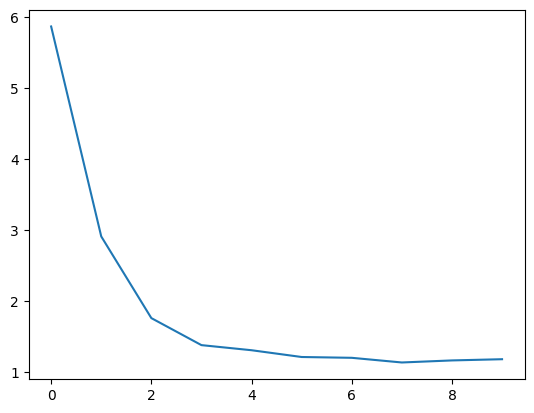

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
# Move the epoch loss tensors to the CPU before plotting
cpu_epoch_loss = [loss.cpu().detach().numpy() for loss in models_dict[256,100,24]['epoch_loss']]
plt.plot(cpu_epoch_loss) # Plot the CPU-based epoch loss

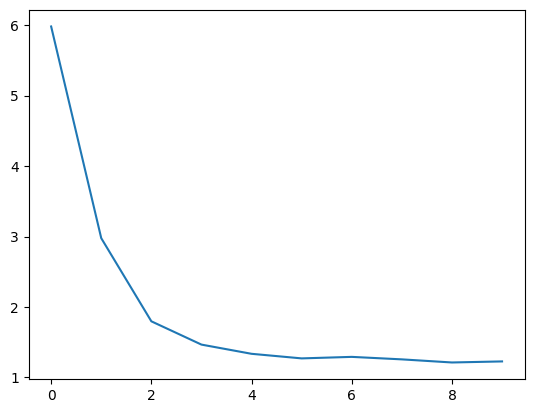

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
# Move the epoch loss tensors to the CPU before plotting
cpu_epoch_loss = [loss.cpu().detach().numpy() for loss in epoch_loss]
plt.plot(cpu_epoch_loss) # Plot the CPU-based epoch loss

In [22]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(i,j):
    cos_sim = dot(genre_embeddings[i], \
                  genre_embeddings[j])/(norm(genre_embeddings[i])*norm(genre_embeddings[j]))

    return cos_sim

In [23]:
batch_dict = {}
batch_dict['genre']=torch.Tensor(list(genres_to_idx.values())).long()
batch_dict['user_id'] = torch.Tensor(full_table['user_id'].unique()).long()
batch_dict['item_id'] = torch.Tensor(full_table['movie_id'].unique()).long()



In [25]:
genre_embeddings = models_dict[256,100,24]['trained_model']("genre",batch=batch_dict['genre'].to('cuda')).cpu().detach().numpy()
movie_embeddings = models_dict[256,100,24]['trained_model']("item_id",batch=batch_dict['item_id'].to('cuda')).cpu().detach().numpy()
user_embeddings = models_dict[256,100,24]['trained_model']("user_id",batch=batch_dict['user_id'].to('cuda')).cpu().detach().numpy()

In [26]:
import numpy as np
cos_matrix = np.zeros([len(genre_embeddings)]*2)
for i in range(len(genre_embeddings)):
    for j in range(len(genre_embeddings)):

        cos_matrix[i,j] = cosine_sim(i,j)

In [27]:
import pandas as pd

pd.DataFrame(cos_matrix, columns=genres, index=genres)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Action,1.000000,0.027512,-0.169624,-0.028744,0.696307,0.275216,-0.066694,0.694222,-0.048459,-0.063667,0.084924,-0.032207,-0.130192,0.061507,0.077760,0.153812,-0.018066,-0.237943
Adventure,0.027512,1.000000,-0.077255,-0.015688,0.059035,-0.048435,-0.009962,0.055298,-0.012423,-0.013928,-0.000128,-0.012441,-0.089994,-0.003073,-0.009788,0.007639,-0.012223,-0.100941
Animation,-0.169624,-0.077255,1.000000,-0.151687,-0.361708,0.344279,-0.112207,-0.433297,-0.146577,-0.174741,-0.080663,-0.150995,0.603258,-0.081298,-0.255792,-0.088175,-0.142980,0.621474
Children's,-0.028744,-0.015688,-0.151687,1.000000,0.001981,-0.183230,-0.015354,0.000885,-0.017919,0.992147,-0.011436,-0.016854,-0.212495,-0.017568,0.978685,-0.015910,-0.016618,-0.195337
Comedy,0.696307,0.059035,-0.361708,0.001981,1.000000,0.114613,-0.037959,0.808307,-0.030478,-0.039758,0.075338,-0.005288,-0.309625,0.088616,0.095665,0.184413,0.012652,-0.444614
Crime,0.275216,-0.048435,0.344279,-0.183230,0.114613,1.000000,-0.131333,0.117787,-0.126950,-0.151423,-0.060534,-0.135039,0.662463,-0.064438,-0.175385,-0.008500,-0.126302,0.454381
Documentary,-0.066694,-0.009962,-0.112207,-0.015354,-0.037959,-0.131333,1.000000,-0.024759,-0.011279,-0.008722,-0.016100,-0.017153,-0.176401,-0.018744,-0.020321,-0.021699,0.995260,-0.113446
Drama,0.694222,0.055298,-0.433297,0.000885,0.808307,0.117787,-0.024759,1.000000,-0.031679,-0.036406,0.081626,-0.004544,-0.309312,0.093334,0.095714,0.194457,0.031228,-0.491492
Fantasy,-0.048459,-0.012423,-0.146577,-0.017919,-0.030478,-0.126950,-0.011279,-0.031679,1.000000,-0.011473,-0.015717,0.997293,-0.141870,-0.018382,-0.021725,-0.031614,-0.013053,-0.121397
Film-Noir,-0.063667,-0.013928,-0.174741,0.992147,-0.039758,-0.151423,-0.008722,-0.036406,-0.011473,1.000000,-0.014650,-0.013008,-0.168542,-0.019625,0.974840,-0.021120,-0.013448,-0.161343


In [28]:
from umap import UMAP

reduced_user = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(user_embeddings)
reduced_movie = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(movie_embeddings)
reduced_genre = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(genre_embeddings)




/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


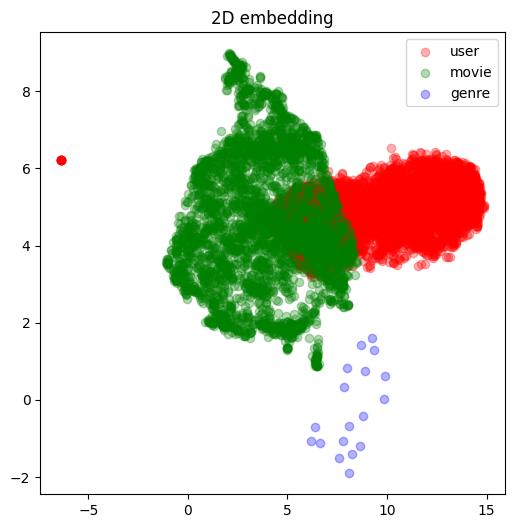

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(reduced_user[:,0],reduced_user[:,1],color='red',alpha=0.3,label="user")
plt.scatter(reduced_movie[:,0],reduced_movie[:,1],color='green',alpha=0.3, label='movie')
plt.scatter(reduced_genre[:,0],reduced_genre[:,1],color="blue",alpha=0.3,label="genre")


plt.legend()

plt.title("2D embedding")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


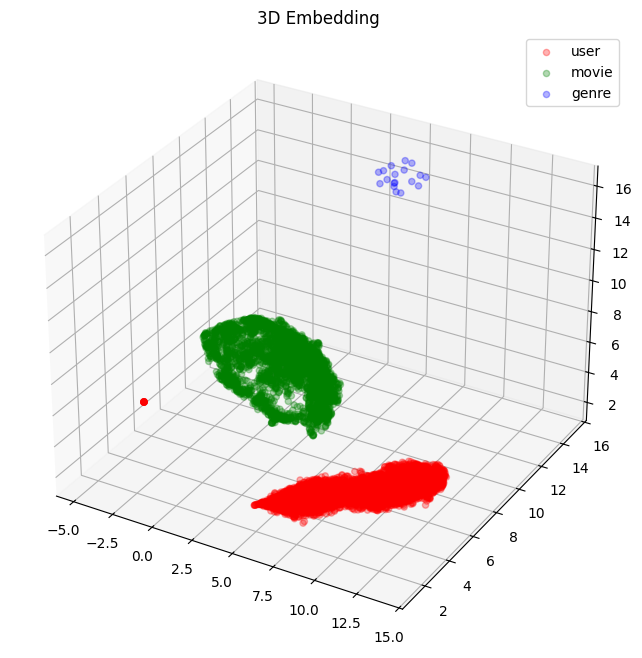

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Perform dimensionality reduction with UMAP for 3 dimensions
reduced_user = UMAP(n_jobs=-1, n_neighbors=5, n_components=3).fit_transform(user_embeddings)
reduced_movie = UMAP(n_jobs=-1, n_neighbors=5, n_components=3).fit_transform(movie_embeddings)
reduced_genre = UMAP(n_jobs=-1, n_neighbors=5, n_components=3).fit_transform(genre_embeddings)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_user[:, 0], reduced_user[:, 1], reduced_user[:, 2], color='red', alpha=0.3, label="user")
ax.scatter(reduced_movie[:, 0], reduced_movie[:, 1], reduced_movie[:, 2], color='green', alpha=0.3, label='movie')
ax.scatter(reduced_genre[:, 0], reduced_genre[:, 1], reduced_genre[:, 2], color="blue", alpha=0.3, label="genre")

ax.legend()
ax.set_title("3D Embedding")

plt.show()

In [30]:
from sklearn.neighbors import kneighbors_graph

graph = kneighbors_graph(movie_embeddings,3, include_self=True, mode='connectivity')

In [31]:
def top_3_rec(elem,graph):

    similar_items = graph[elem].nonzero()[1].tolist()
    return items[items.movie_id.isin(similar_items)]

In [33]:
top_3_rec(64,graph)

,movie_id,movie_title,genres,genre_list,genre_list_idx
63,64,Two if by Sea (1996),Comedy|Romance,"[Comedy, Romance]","[4, 13]"
122,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,[Drama],[7]
705,714,Dead Man (1995),Western,[Western],[17]
